In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pytz
import doctest

In [107]:
# doctest.testmod(verbose=True)

In [108]:
def transform_crypto_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    This function adds the following columns to our bitcoin dataframe:
    %PriceChange: To look at price change within a day
    priceDiff: To look at the per day absolute price change
    normalizedVol: To compare relative trading activity
    7DayMovingAvgPrice: To be able to observe long-term effects
    30DayMovingAvgPrice: To be able to observe long-term effects
    7DayMovingAvgVol: To be able to observe long-term effects
    30DayMovingAvgVol: To be able to observe long-term effects
    
    Note: The first 7 or 30 values for Moving averages for a week or month, respectively,
        are NaN values because there aren't sufficient rows to calculate the average. 
        We have decided to leave these values as NaN to preserve data integrity and not fill
        them which could possibly distort our analysis.
    
    Add doctests to see if the calculations are correct -> doctests for this function added under doctests in get_crypto_data function
    
    :param data: bitcoin dataframe
    :return: data: bitcoin dataframe with the columns above
    """
    # Adding column for % Price Change per day 
    data['%PriceChange'] = abs(round(((data['Close'] - data['Open']) / data['Open']) * 100, 3))
    
    # Normalizing %PriceChange
    data['normalizedPriceChange'] = data['%PriceChange'] / data['%PriceChange'].abs().max()
    
    # Adding column for price difference
    data['priceDiff'] = round(data['Close'] - data['Open'], 3)
    
    # Adding column to look at the normalized trading volume
    data['normalizedVol'] = data['Volume'] / data['Volume'].max()
    
    # Adding columns for moving averages to compare long-term results
    # Learnt about the rolling function through ChatGPT
    data['7DayMovingAvgPrice'] = round(data['Close'].rolling(window=7).mean(), 3)
    data['30DayMovingAvgPrice'] = round(data['Close'].rolling(window=30).mean(), 3)
    data['7DayMovingAvgVol'] = data['normalizedVol'].rolling(window=7).mean()
    data['30DayMovingAvgVol'] = data['normalizedVol'].rolling(window=30).mean()
    
    return data

In [109]:
def get_crypto_data(filename: str) -> pd.DataFrame:
    """
    Reads the bitcoin csv data into a pandas dataframe.
    
    :param filename: bitcoin csv file name
    :return: df: bitcoin data as a pandas dataframe
    
    >>> import pandas as pd
    >>> from io import StringIO
    >>> test_csv = '''Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
    ... 2014-09-17 00:00:00+00:00,465.864013671875,468.17401123046875,452.4219970703125,457.3340148925781,21056800,0.0,0.0
    ... 2014-09-18 00:00:00+00:00,456.8599853515625,456.8599853515625,413.10400390625,424.44000244140625,34483200,0.0,0.0
    ... 2014-09-19 00:00:00+00:00,424.1029968261719,427.8349914550781,384.5320129394531,394.7959899902344,37919700,0.0,0.0
    ... 2014-09-20 00:00:00+00:00,394.6730041503906,423.2959899902344,389.88299560546875,408.90399169921875,36863600,0.0,0.0
    ... 2014-09-21 00:00:00+00:00,408.0849914550781,412.4259948730469,393.1809997558594,398.8210144042969,26580100,0.0,0.0'''
    >>> filename = StringIO(test_csv)
    >>> result = get_crypto_data(filename)
    >>> result['Date'].iloc[0]  # checking to see if first 'Date' value is correct.
    Timestamp('2014-09-17 00:00:00+0000', tz='UTC')
    >>> result.shape  # Check the DataFrame dimensions
    (5, 16)
    >>> round(result['%PriceChange'].iloc[0], 3) 
    np.float64(-1.831)
    >>> round(result['normalizedVol'].iloc[0], 3) 
    np.float64(0.555)
    >>> round(result['7DayMovingAvgPrice'].iloc[4], 3)
    np.float64(nan)
    """
    
    df = pd.read_csv(filename)
    
    # converting 'Date' column to pd.datetime format to perform calculations
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    
    df = transform_crypto_data(df)
    
    return df

In [110]:
bitcoin_df = get_crypto_data('bitcoin_historical_data.csv')

In [111]:
eth_df = get_crypto_data('ETH_data.csv')

### Reading Policy Data into Pandas DataFrame

In [112]:
def get_US_law_data(filename: str) -> pd.DataFrame:
    """
    This function reads the US Law data csv file into a pandas dataframe.
    
    :param filename: name of file with US Law data
    :return: dataframe containing US Law data
    
    >>> df = get_US_law_data('results_US.csv')
    >>> df.shape
    (97, 18)
    >>> df['Latest Action Date'].dtype
    dtype('<M8[ns]')
    """
    
    df = pd.read_csv(filename)
    
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'])
    df['Latest Action Date'] = pd.to_datetime(df['Latest Action Date'])
    
    # Making law data timezone aware to EST, since bitcoin data is timezone-aware
    df['Date of Introduction'] = df['Date of Introduction'].dt.tz_localize('UTC')
    est_tz = pytz.timezone('US/Eastern')
    df['Date of Introduction'] = df['Date of Introduction'].dt.tz_convert(est_tz)
    
    return df

In [113]:
law_df = get_US_law_data('results_US.csv')

### Adding Event Period Flag to Crypto Data
* If the date from cryptocurrency data is within a week from Policy date (Date of Introduction), it is flagged as 1, else 0

In [114]:
def event_period_flag(row, eventdates) -> int:
    """
    This function adds a flag (1) if an observation from the cryptocurrency dataset falls within a week from an Event (Introduction of a bill).
    
    :param row: Observation from cryptocurrency data
    :param eventdates: contains a list of dates of event
    :return: 0 or 1 depending on the flag
    
    >>> eventdates = [pd.Timestamp('2024-01-01'), pd.Timestamp('2024-01-15')]
    >>> event_period_flag(pd.Timestamp('2024-01-03'), eventdates)
    1
    >>> event_period_flag(pd.Timestamp('2024-01-10'), eventdates)
    0
    >>> event_period_flag(pd.Timestamp('2024-01-16'), eventdates)
    1
    >>> event_period_flag(pd.Timestamp('2024-01-23'), eventdates)
    0
    """
    for eventdate in eventdates:
        # Event window: 7 days from the event date/ 1 week
        event_startwindow = eventdate
        event_endwindow = eventdate + pd.Timedelta(days=7)  # 7-day window from the event date
        
        # 1 if date falls during an event, 0 if it does not
        if event_startwindow <= row <= event_endwindow:
            return 1  # DuringEvent
    
    return 0

In [115]:
# Adding column 'EventPeriod' to bitcoin_df. It is a flag where 1 means the date was during an event (bill introduction)
event_dates = law_df['Date of Introduction'].tolist()
bitcoin_df['EventPeriod'] = bitcoin_df['Date'].apply(lambda x: event_period_flag(x, event_dates))
eth_df['EventPeriod'] = eth_df['Date'].apply(lambda x: event_period_flag(x, event_dates))

### Studying Price trends within our Bitcoin data: Exploratory Data Analysis

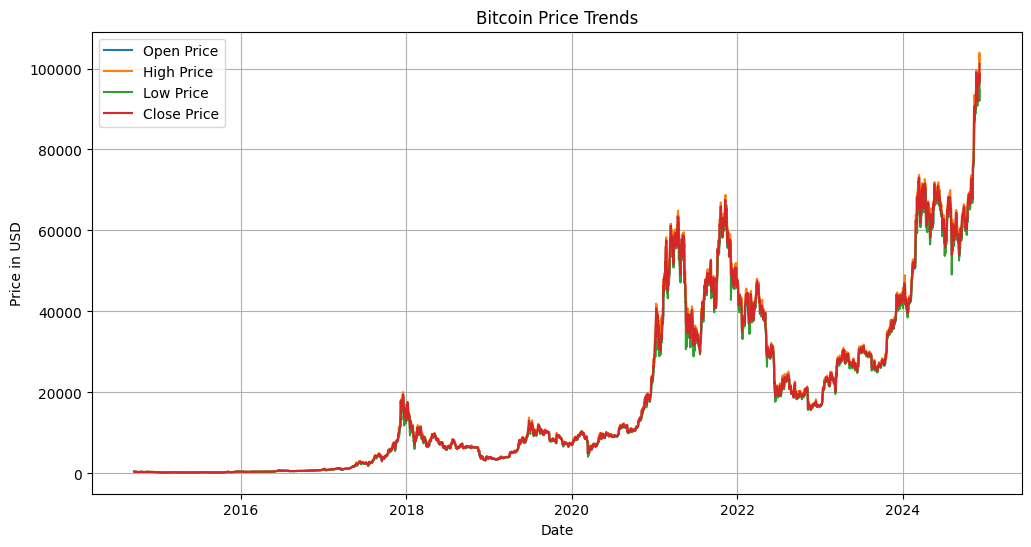

In [116]:
# Observing price trends (Open, High, Low, Close)
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Open'], label='Open Price')
plt.plot(bitcoin_df['Date'], bitcoin_df['High'], label='High Price')
plt.plot(bitcoin_df['Date'], bitcoin_df['Low'], label='Low Price')
plt.plot(bitcoin_df['Date'], bitcoin_df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price Trends')
plt.legend()
plt.grid(True)
plt.show()

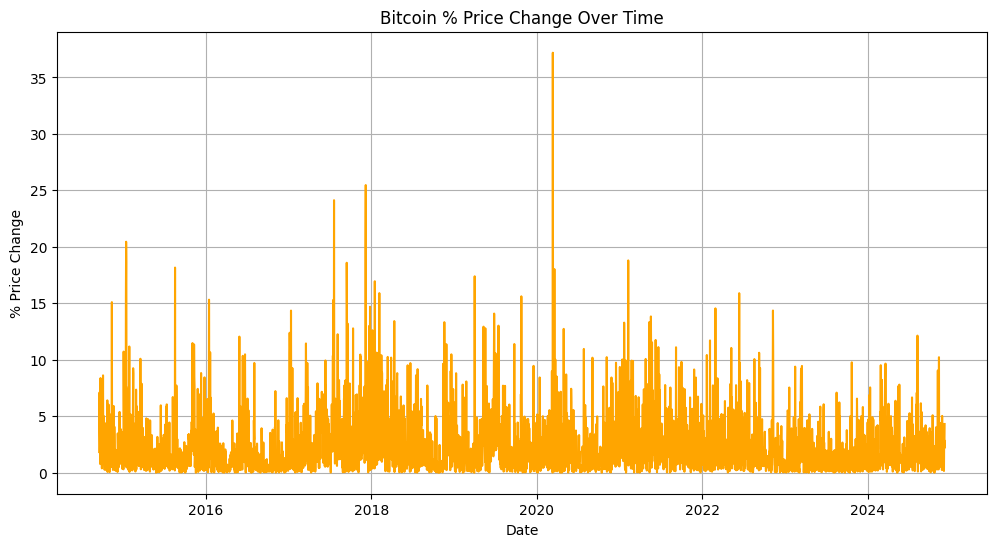

In [117]:
#  % price change over time
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['%PriceChange'], label='% Price Change', color='orange')
plt.xlabel('Date')
plt.ylabel('% Price Change')
plt.title('Bitcoin % Price Change Over Time')
plt.grid(True)
plt.show()

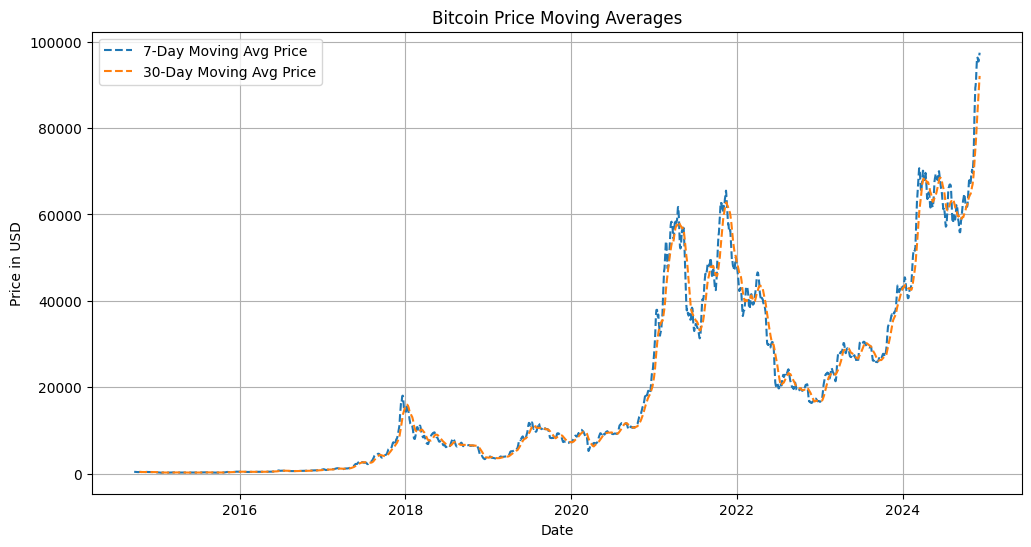

In [118]:
# price averages over time
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['7DayMovingAvgPrice'], label='7-Day Moving Avg Price', linestyle='--')
plt.plot(bitcoin_df['Date'], bitcoin_df['30DayMovingAvgPrice'], label='30-Day Moving Avg Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

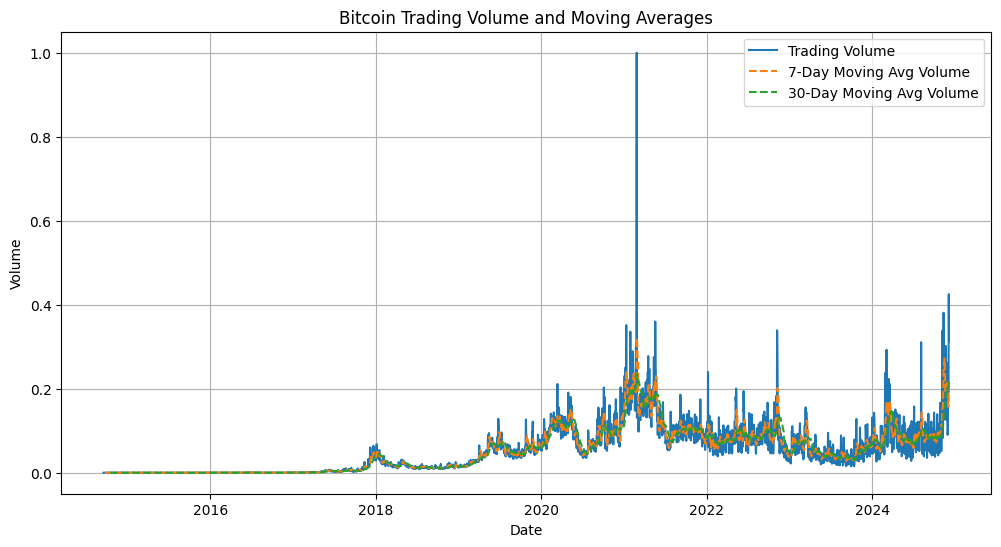

In [119]:
# trading volume averages
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['normalizedVol'], label='Trading Volume')
plt.plot(bitcoin_df['Date'], bitcoin_df['7DayMovingAvgVol'], label='7-Day Moving Avg Volume', linestyle='--')
plt.plot(bitcoin_df['Date'], bitcoin_df['30DayMovingAvgVol'], label='30-Day Moving Avg Volume', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Bitcoin Trading Volume and Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

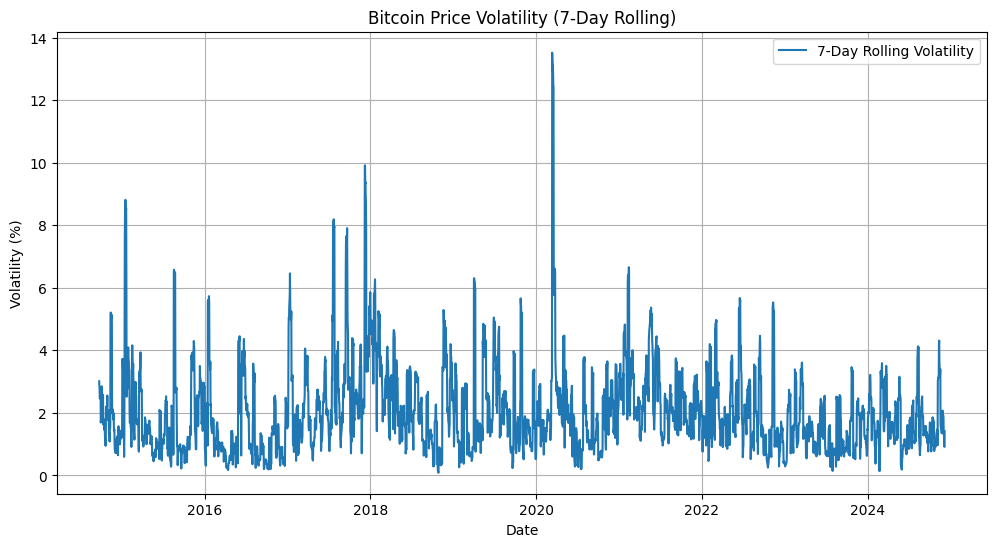

In [120]:
# calculating rolling standard deviation for price change (volatility)
bitcoin_df['Volatility'] = bitcoin_df['%PriceChange'].rolling(window=7).std()

# Plotting the volatility
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Volatility'], label='7-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.title('Bitcoin Price Volatility (7-Day Rolling)')
plt.grid(True)
plt.legend()
plt.show()


### Calculating statistics for observations During the event of a Policy introduction:
* Average price change During vs. Average price change in general (not including cryptocurrency data during an event)
* Volatility during event vs. Volatility for general observations
* Average daily price range (High - Low) for during vs. non-during
* Looking at Volatiltiy and Volume for during vs. non-during

In [121]:
def calculate_avg_price_change(data: pd.DataFrame, start_year: int, end_year: int) -> list:
    """
    Calculates the average % price change during the event period.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :param start_year: start of range
    :param end_year: end of range
    :return: value average % price change
    
    >>> data = pd.DataFrame({
    ...     'Date': pd.to_datetime(['2019-01-01', '2020-06-01', '2021-03-15', '2018-12-01', '2021-11-05']),
    ...     'EventPeriod': [1, 0, 1, 0, 1],
    ...     'normalizedPriceChange': [0.05, -0.02, 0.03, -0.01, 0.07]
    ... })
    >>> calculate_avg_price_change(data, 2019, 2021)
    [np.float64(0.05), np.float64(-0.02)]
    
    >>> empty_data = pd.DataFrame(columns=['Date', 'EventPeriod', 'normalizedPriceChange'])
    >>> calculate_avg_price_change(empty_data, 2018, 2020)
    [0, 0]
    
    >>> no_events_data = pd.DataFrame({
    ...     'Date': pd.to_datetime(['2020-01-01', '2020-06-01', '2020-12-01']),
    ...     'EventPeriod': [0, 0, 0],
    ...     'normalizedPriceChange': [-0.01, 0.00, 0.02]
    ... })
    >>> calculate_avg_price_change(no_events_data, 2020, 2020)
    [0, np.float64(0.003)]
    
    >>> no_non_events_data = pd.DataFrame({
    ...     'Date': pd.to_datetime(['2019-01-01', '2019-06-01', '2019-12-01']),
    ...     'EventPeriod': [1, 1, 1],
    ...     'normalizedPriceChange': [0.02, 0.03, 0.01]
    ... })
    >>> calculate_avg_price_change(no_non_events_data, 2019, 2019)
    [np.float64(0.02), 0]
    """
    
    # get filtered data that falls within the year range (start_year and end_year)
    data = data[(data['Date'].dt.year >= start_year) & (data['Date'].dt.year <= end_year)]
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    avg_price_change_during = round(during_event_data['normalizedPriceChange'].mean(), 3) if not during_event_data.empty else 0
    avg_price_change_general = round(non_event_data['normalizedPriceChange'].mean(), 3) if not non_event_data.empty else 0
    
    return [avg_price_change_during, avg_price_change_general]

In [122]:
avg_price_changes = calculate_avg_price_change(bitcoin_df, 2017, 2021)
avg_price_changes


[np.float64(0.075), np.float64(0.077)]

In [123]:
def calculate_volatility(data: pd.DataFrame, start_year: int, end_year: int) -> list:
    """
    Calculates the price volatility (standard deviation of %PriceChange) during and non-event periods. Gives us a sense of price fluctuation.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :param start_year: start of range
    :param end_year: end of range
    :return: List with volatility for both during event and non-event periods.
    
    >>> import pandas as pd
    >>> data = pd.DataFrame({
    ...     'EventPeriod': [1, 0, 1, 0, 1],
    ...     'normalizedPriceChange': [0.05, -0.02, 0.03, -0.01, 0.07],
    ...     'Year': [2018, 2019, 2020, 2021, 2022]
    ... }, dtype='float64')
    >>> calculate_volatility(data, start_year=2018, end_year=2022)
    {'During Event': np.float64(0.02), 'General': np.float64(0.007)}

    >>> empty_data = pd.DataFrame(columns=['EventPeriod', 'normalizedPriceChange', 'Year'], dtype='float64')
    >>> calculate_volatility(empty_data, start_year=2018, end_year=2022)
    {'During Event': 0, 'General': 0}
    """
    data = data[(data['Date'].dt.year >= start_year) & (data['Date'].dt.year <= end_year)]
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    # calculating the std dev of normalized price change
    volatility_during = round(during_event_data['normalizedPriceChange'].std(), 3) if not during_event_data.empty else 0
    volatility_general = round(non_event_data['normalizedPriceChange'].std(), 3) if not non_event_data.empty else 0
    
    return [volatility_during, volatility_general]

In [124]:
volatility_changes = calculate_volatility(bitcoin_df, 2017, 2024)
print(volatility_changes)

[np.float64(0.076), np.float64(0.075)]


In [125]:
def calculate_price_range(data: pd.DataFrame, start_year: int, end_year: int) -> list:
    """
    Calculates the average daily price range (high-low difference) during and non-event periods. You can calculate the daily high-low range of the price, which captures the extremes of the price movements and can show how much the price fluctuated within each day. This will help highlight the day-to-day volatility.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :param start_year: start of range
    :param end_year: end of range
    :return: Dictionary with average price range for both during event and non-event periods.
    
    >>> import pandas as pd
    >>> data = pd.DataFrame({
    ...     'EventPeriod': [1, 0, 1, 0, 1],
    ...     'High': [50000, 49500, 50500, 49000, 51000],
    ...     'Low': [49500, 49000, 50000, 48500, 50500]
    ... }, dtype='float64')
    >>> calculate_price_range(data)
    {'During Event': np.float64(500.0), 'General': np.float64(500.0)}

    >>> empty_data = pd.DataFrame(columns=['EventPeriod', 'High', 'Low'], dtype='float64')
    >>> calculate_price_range(empty_data)
    {'During Event': 0, 'General': 0}
    """
    
    data = data[(data['Date'].dt.year >= start_year) & (data['Date'].dt.year <= end_year)]
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    # calculating avg price range (high - low)
    avg_range_during = round((during_event_data['High'] - during_event_data['Low']).mean(), 3) if not during_event_data.empty else 0
    avg_range_general = round((non_event_data['High'] - non_event_data['Low']).mean(), 3) if not non_event_data.empty else 0
    
    return [avg_range_during, avg_range_general]

In [126]:
price_ranges = calculate_price_range(bitcoin_df, 2017, 2024)
print(price_ranges)

[np.float64(1300.539), np.float64(1092.913)]


In [127]:
def calculate_avg_volatility_and_volume(data: pd.DataFrame):
    """
    Calculates average price volatility and trading volume during and non-event periods.
    
    :param data: bitcoin_df with an 'EventPeriod' column.
    :return: Dictionary with volatility and volume for both during event and non-event periods.
    
    >>> import pandas as pd
    >>> data = pd.DataFrame({
    ...     'EventPeriod': [1, 0, 1, 0, 1],
    ...     'normalizedPriceChange': [0.05, 0.02, 0.07, 0.01, 0.06],
    ...     'normalizedVol': [200, 150, 250, 100, 300]
    ... }, dtype='float64')
    >>> calculate_avg_volatility_and_volume(data)
    {'During Event': {'Volatility': np.float64(0.01), 'Avg Volume': np.float64(250.0)}, 'General': {'Volatility': np.float64(0.007), 'Avg Volume': np.float64(125.0)}}

    >>> empty_data = pd.DataFrame(columns=['EventPeriod', 'normalizedPriceChange', 'normalizedVol'], dtype='float64')
    >>> calculate_avg_volatility_and_volume(empty_data)
    {'During Event': {'Volatility': 0, 'Avg Volume': 0}, 'General': {'Volatility': 0, 'Avg Volume': 0}}
    """
    
    during_event_data = data[data['EventPeriod'] == 1]
    non_event_data = data[data['EventPeriod'] == 0]

    # calculating price volatility (std of normalized price change)
    volatility_during = round(during_event_data['normalizedPriceChange'].std(), 3) if not during_event_data.empty else 0
    volatility_general = round(non_event_data['normalizedPriceChange'].std(), 3) if not non_event_data.empty else 0
    
    # calculating the avg trading volume
    avg_vol_during = round(during_event_data['normalizedVol'].mean(), 3) if not during_event_data.empty else 0
    avg_vol_general = round(non_event_data['normalizedVol'].mean(), 3) if not non_event_data.empty else 0
    
    return {
        'During Event': {'Volatility': volatility_during, 'Avg Volume': avg_vol_during},
        'General': {'Volatility': volatility_general, 'Avg Volume': avg_vol_general}
    }

volatility_and_volume = calculate_avg_volatility_and_volume(bitcoin_df)
print(volatility_and_volume)


{'During Event': {'Volatility': np.float64(0.076), 'Avg Volume': np.float64(0.077)}, 'General': {'Volatility': np.float64(0.073), 'Avg Volume': np.float64(0.048)}}


In [128]:
def plot_avg_yearly_price_change(data: pd.DataFrame, start_year: int, end_year: int):
    """
    This function plots the average yearly price change.
    
    :param data: bitcoin_df
    :param start_year: start of range
    :param end_year: end of range
    :return: Nothing, just displays the plot
    """
    
    avg_during_event = []
    avg_non_event = []
    years = range(start_year, end_year + 1)
    
    for year in years:
        avg_val = calculate_avg_price_change(data, year, year)
        avg_during_event.append(avg_val[0])
        avg_non_event.append(avg_val[1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(years, avg_during_event, label='During Event', marker='o')
    plt.plot(years, avg_non_event, label='Non Event', marker='o')
    plt.title('Average Average Yearly Price Change')
    plt.xlabel('Year')
    plt.ylabel('Average % Price Change')
    plt.legend()
    plt.grid(True)
    plt.show()

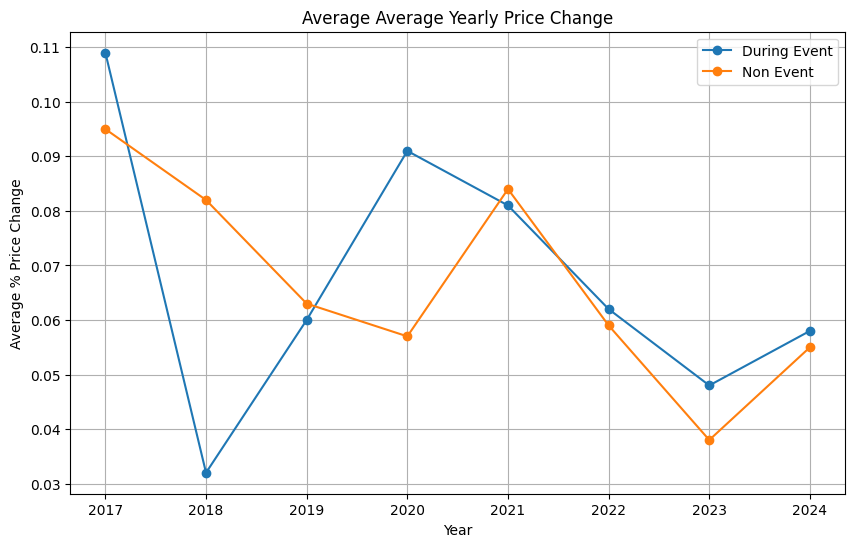

In [129]:
plot_avg_yearly_price_change(bitcoin_df, 2017, 2024)

In [130]:
def plot_yearly_volatility(data: pd.DataFrame, start_year: int, end_year: int):
    """
    This functions plots the yearly avg price volatility values, comparing during-event and non-event values.
    
    :param data: bitcoin_df
    :param start_year: start of range
    :param end_year: end of range
    :return: Does not return anything but plots the chart
    """
    
    volatility_during_event = []
    volatility_non_event = []
    years = range(start_year, end_year + 1)
    
    for year in years:
        volatility_val = calculate_volatility(data, year, year)
        volatility_during_event.append(volatility_val[0])
        volatility_non_event.append(volatility_val[1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(years, volatility_during_event, label='During Event', marker='o')
    plt.plot(years, volatility_non_event, label='Non Event', marker='o')
    plt.title('Yearly Average Price Volatility')
    plt.xlabel('Year')
    plt.ylabel('Volatility (Standard Deviation of Price Change)')
    plt.legend()
    plt.grid(True)
    plt.show()

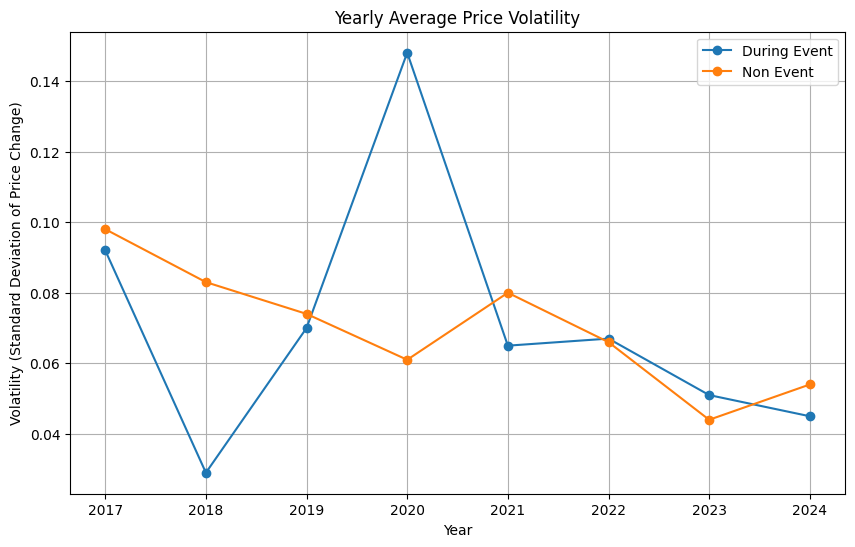

In [131]:
plot_yearly_volatility(bitcoin_df, 2017, 2024)

In [132]:
def plot_yearly_price_range(data: pd.DataFrame, start_year: int, end_year: int):
    price_range_during_event = []
    price_range_non_event = []
    years = range(start_year, end_year + 1)
    
    for year in years:
        price_range_val = calculate_price_range(data, year, year)
        price_range_during_event.append(price_range_val[0])
        price_range_non_event.append(price_range_val[1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(years, price_range_during_event, label='During Event', marker='o')
    plt.plot(years, price_range_non_event, label='Non Event', marker='o')
    plt.title('Yearly Price Range (High-Low Difference)')
    plt.xlabel('Year')
    plt.ylabel('Price Range ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

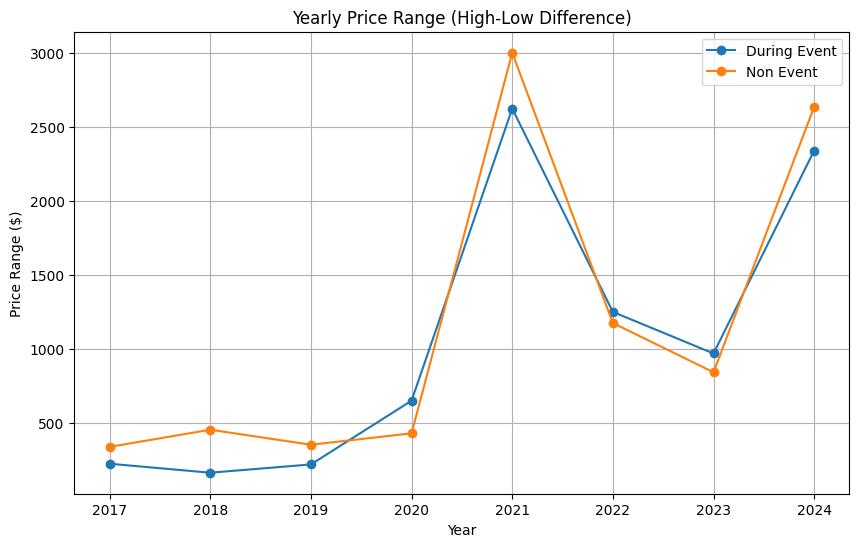

In [133]:
plot_yearly_price_range(bitcoin_df, 2017, 2024)

### Function to create plots that compare Cryptocurrency Trends with Event Period

In [134]:
def plot_quarterly_trend(bitcoin_data: pd.DataFrame, law_data: pd.DataFrame, column_name: str, y_axis_limit=False):
    """
    This function loops through each year from 2018 to 2024 and creates a plot for each quarter to look for trends 
    from two datasets: bitcoin_df and law_df.
    
    :param bitcoin_data: pandas dataframe that contains bitcoin data.
    :param law_data: pandas dataframe that contains data regarding US laws and regulations pertaining to cryptocurrencies, blockchain, or bitcoin.
    :param column_name: This argument allows us to select a column from the bitcoin_df to compare it with the law/regulations data
    :param y_axis_limit: This argument is to set a limit from [-1, 1] for the y-axis. Helps with uniformity when looking at normalized values.
    :return: Does not return anything. Prints out the plots that we observe.
    """
    
    for year in range(2020, 2025):
        for quarter in range(1, 5):
            # defining the start date and end date for the current quarter
            start_date = pd.to_datetime(f'{year}-{(quarter-1)*3+1:02d}-01')
            end_date = pd.to_datetime(f'{year}-{quarter*3:02d}-01') + pd.DateOffset(months=1) - pd.Timedelta(days=1)
    
            # converting start_date and end_date to UTC
            start_date = start_date.tz_localize('US/Eastern').tz_convert('UTC')
            end_date = end_date.tz_localize('US/Eastern').tz_convert('UTC')
    
            # filtering out bitcoin data for the quarter
            bitcoin_df_quarter = bitcoin_data[(bitcoin_data['Date'] >= start_date) & (bitcoin_data['Date'] <= end_date)]
    
            # filtering out event dates for the quarter
            event_dates_quarter = law_data[(law_data['Date of Introduction'] >= start_date) & 
                                          (law_data['Date of Introduction'] <= end_date)]['Date of Introduction'].tolist()
    
            fig, ax = plt.subplots(figsize=(10, 6))
            
            ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

            # plotting bitcoin trend for the quarter
            ax.plot(bitcoin_df_quarter['Date'], bitcoin_df_quarter[column_name], label=column_name, color='b', linestyle='-', marker='o')
    
            # marking "DuringEvent" with shaded regions and event dates with vertical lines
            for event_date in event_dates_quarter:
                # marking the 7-day event window
                event_start_window = event_date
                event_end_window = event_date + pd.Timedelta(days=7)
    
                # converting event window to UTC timezone-aware
                event_start_window = event_start_window.tz_convert('UTC')
                event_end_window = event_end_window.tz_convert('UTC')
    
                # shading region that marks event period (7 days from introduction of bill)
                ax.axvspan(event_start_window, event_end_window, color='gray', alpha=0.2)
    
                # Adding a vertical line for each Date of Introduction to see when the bill was introduced
                ax.axvline(event_date, color='r', linestyle='--')
    
            # Custom legend elements
            legend_elements = [
                Line2D([0], [0], color='b', linestyle='-', marker='o', label=column_name),
                Patch(facecolor='gray', alpha=0.2, label='Event Period'),
                Line2D([0], [0], color='r', linestyle='--', label='Event Date')
            ]
    
            ax.legend(handles=legend_elements, loc='upper left')
    
            ax.set_title(f'Bitcoin {column_name} with Policy Events - {year} Q{quarter}', fontsize=15)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('% Price Change', fontsize=12)
    
            # if y_axis_limit = True, set y-axis limit from -1 to 1. We use this when we visualize normalized values to get uniform plots
            if y_axis_limit:
                ax.set_ylim(-1, 1)
    
            plt.xticks()
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
            # Tight layout for better spacing
            plt.tight_layout()
            
            plt.show()
            plt.close()


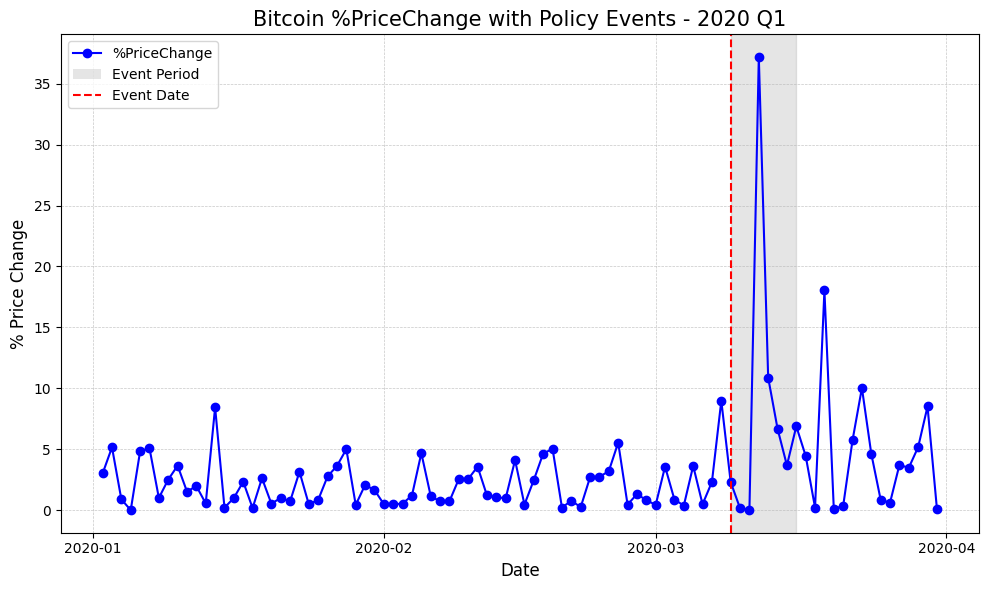

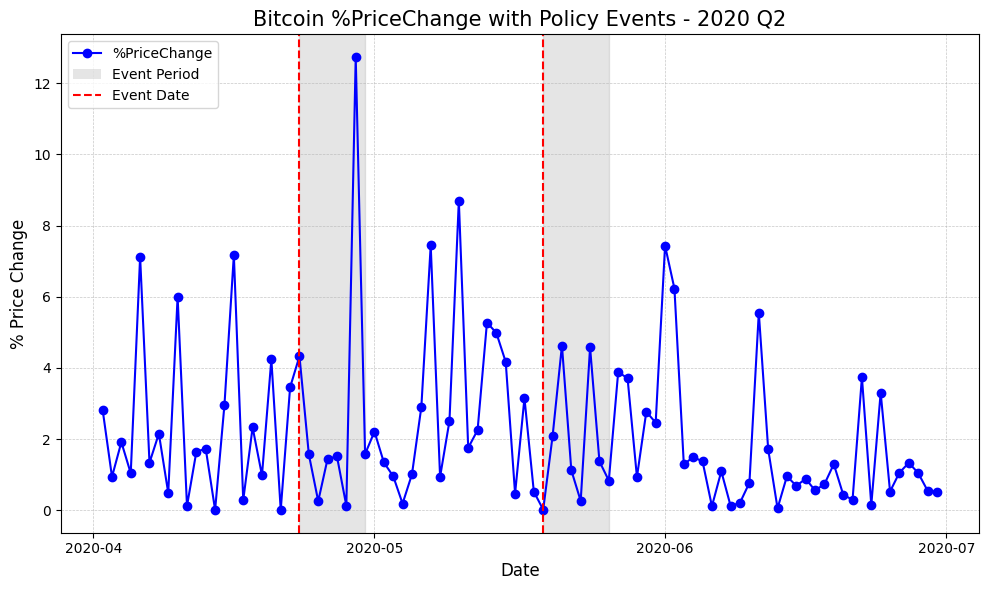

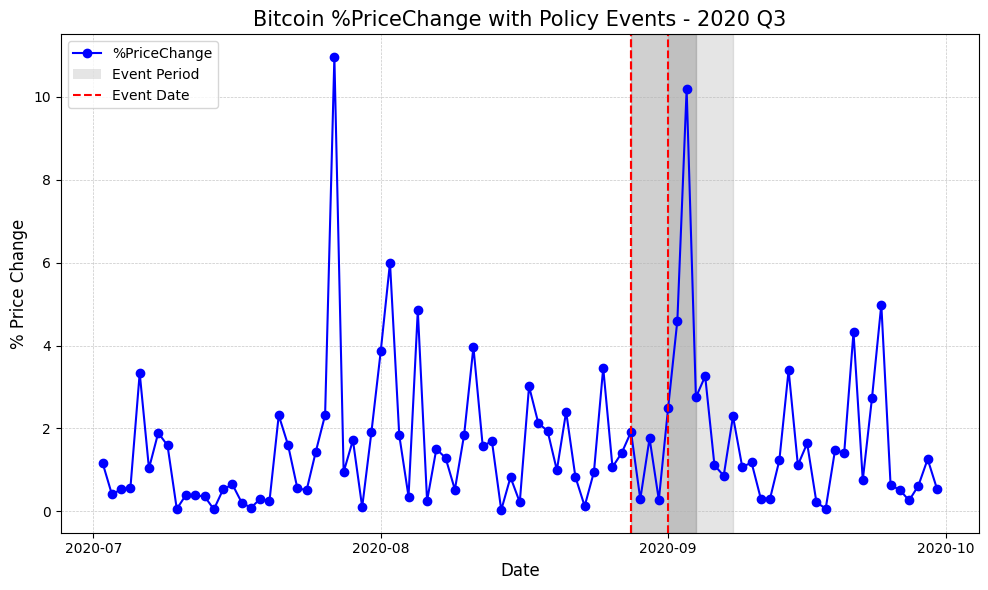

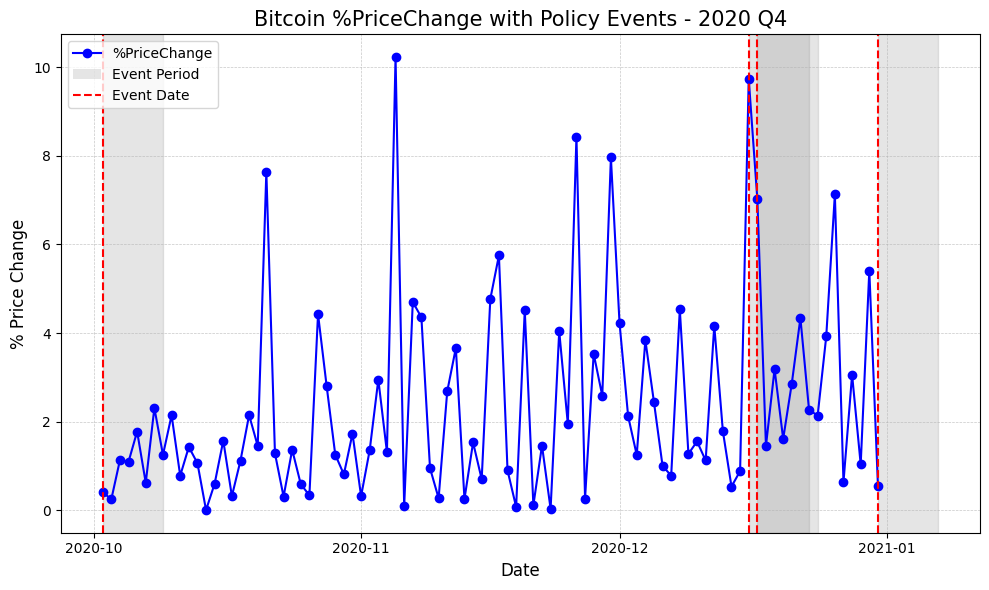

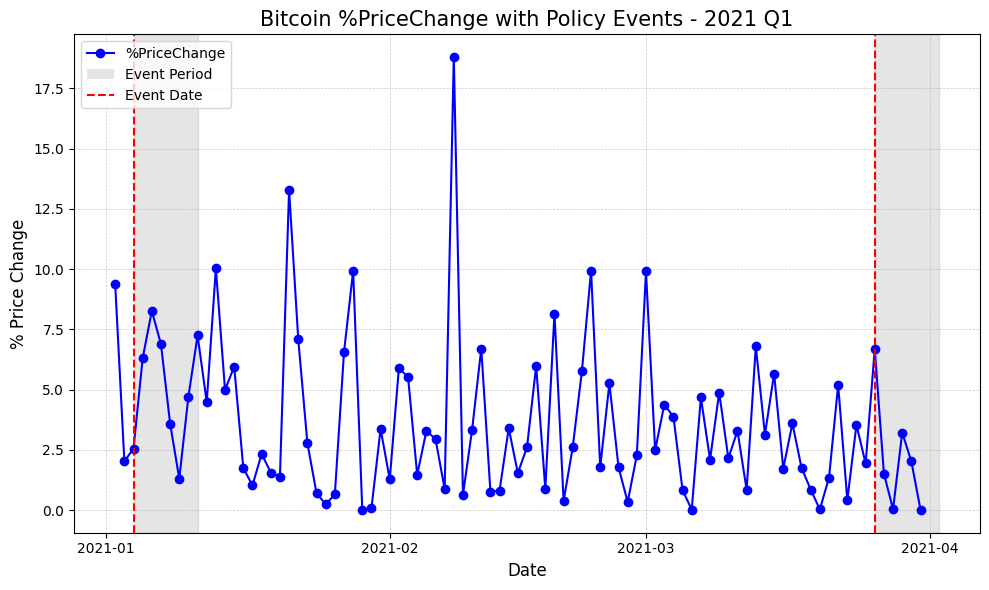

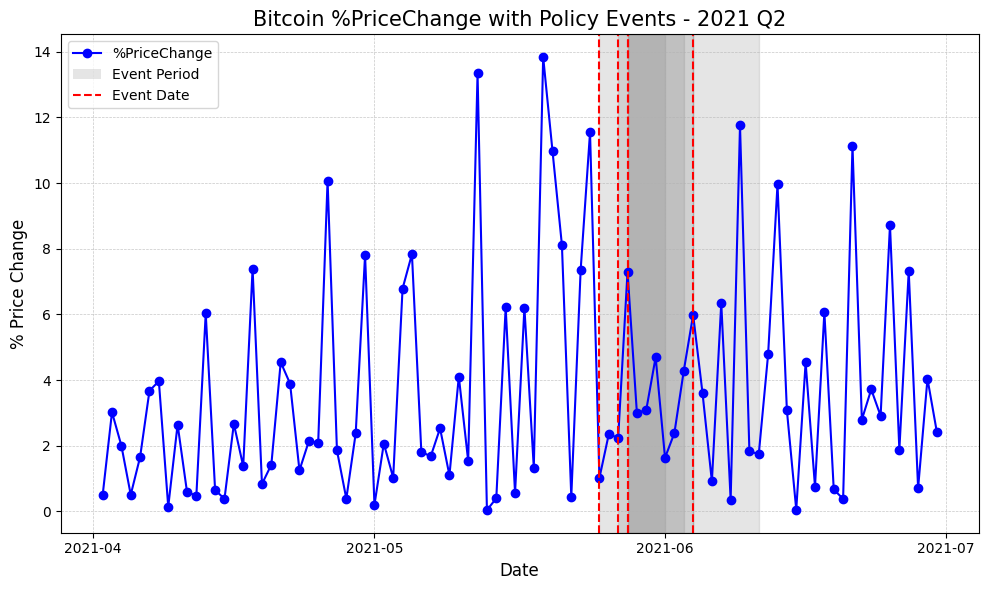

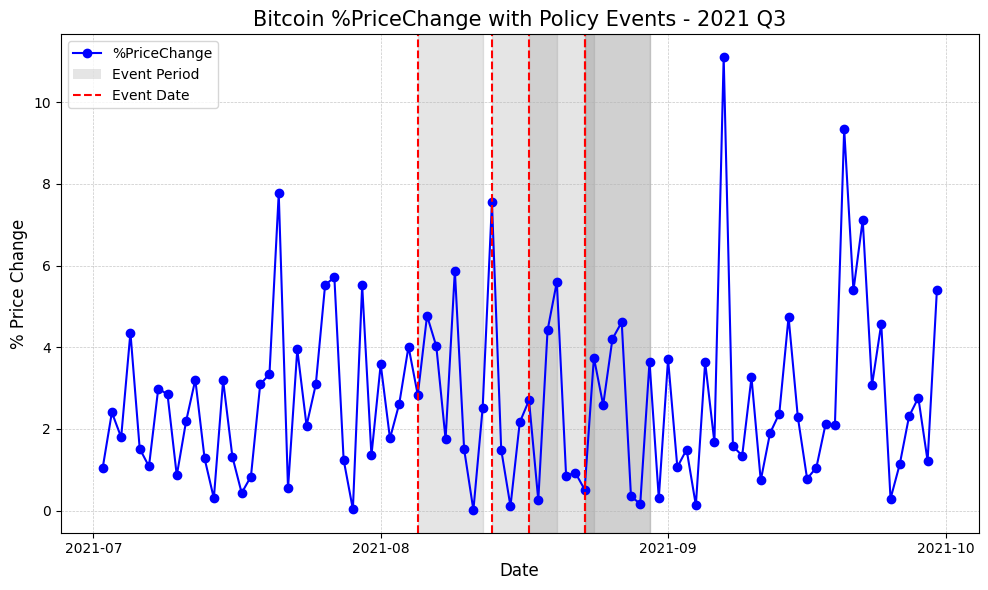

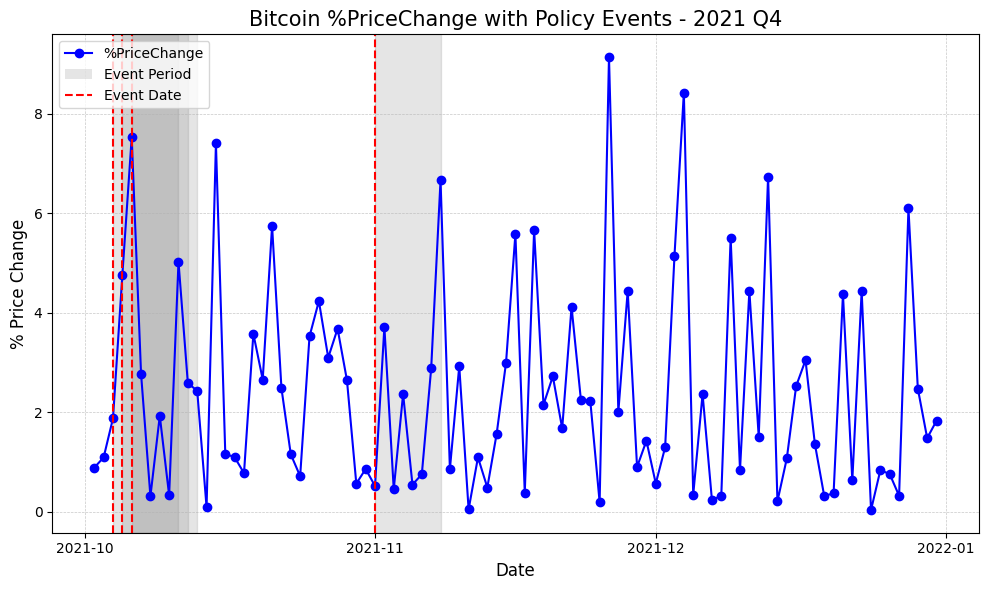

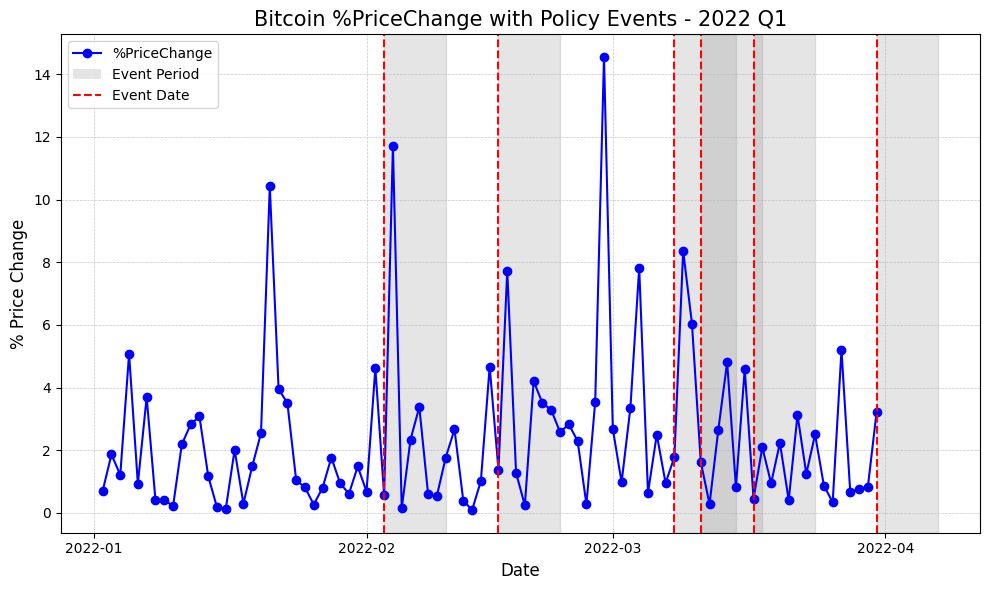

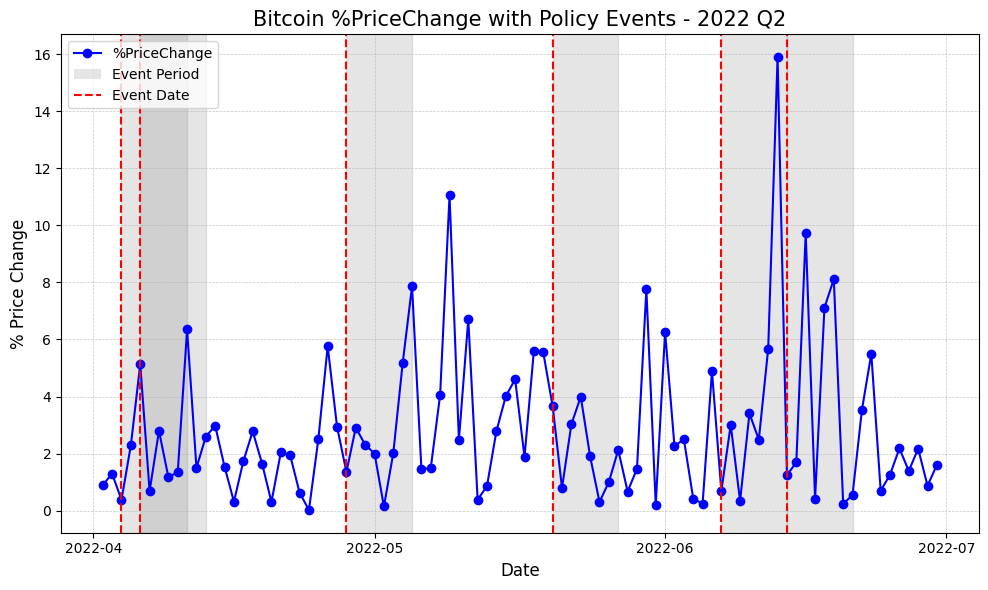

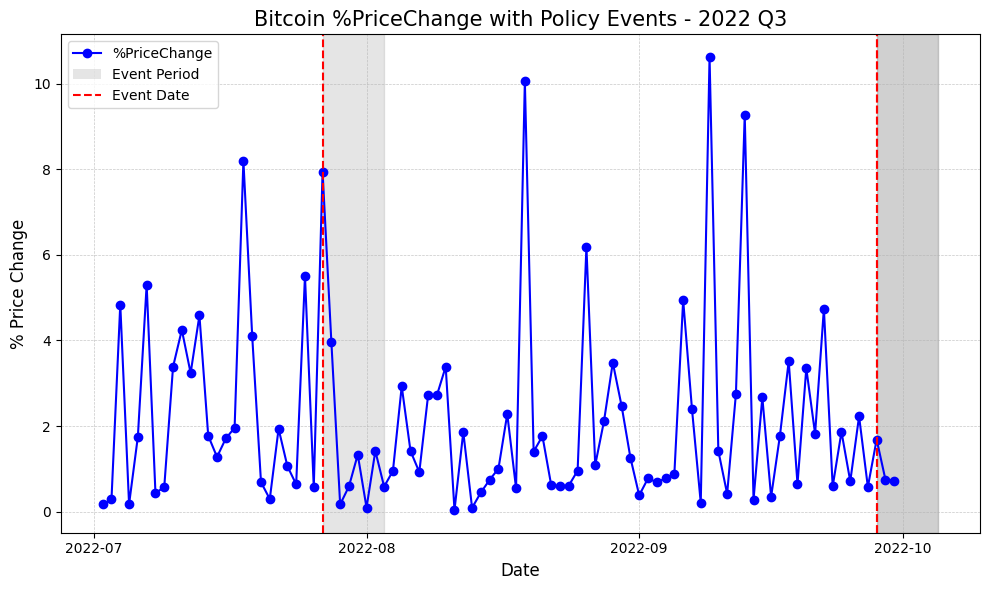

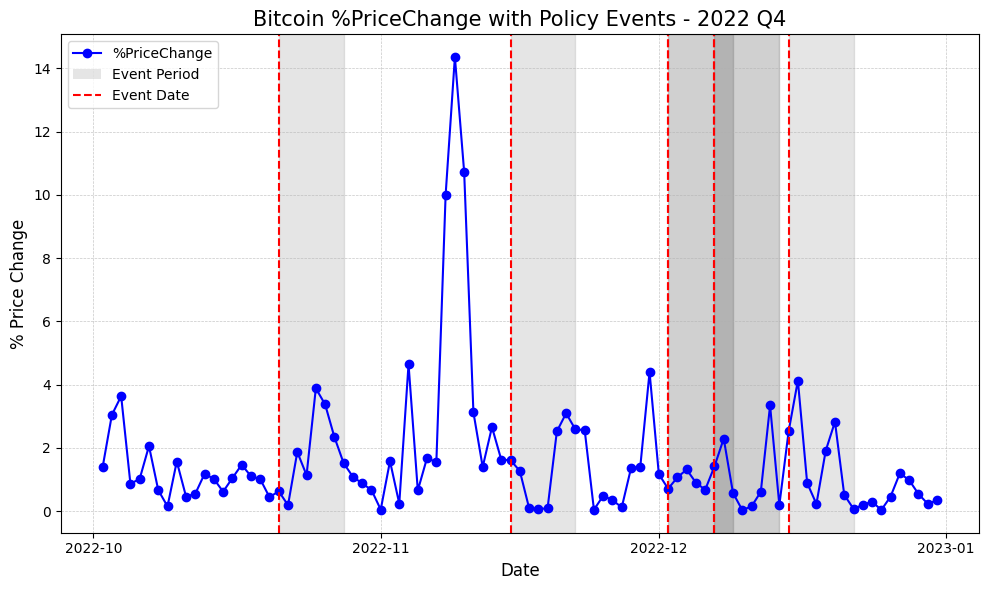

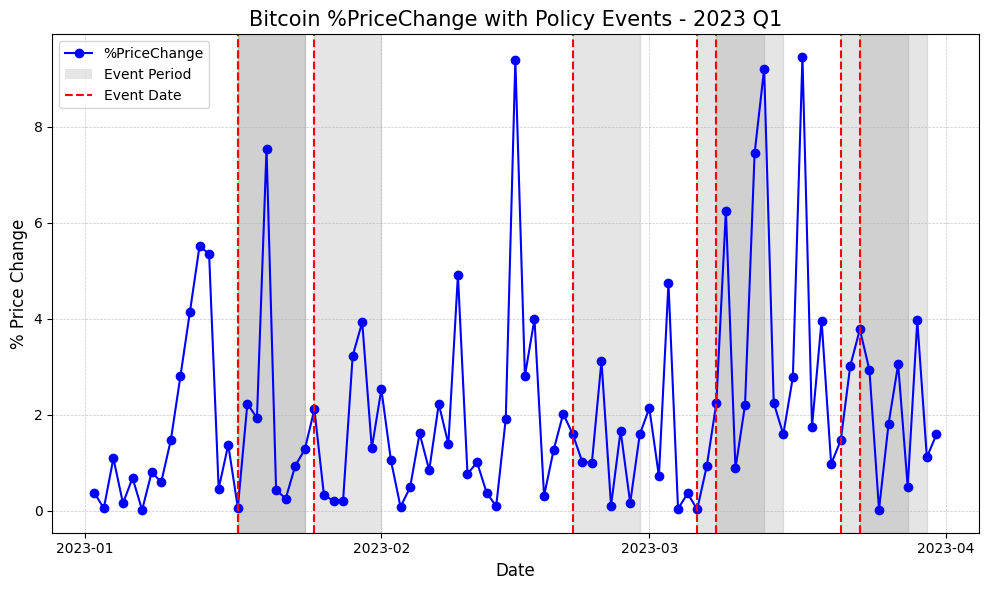

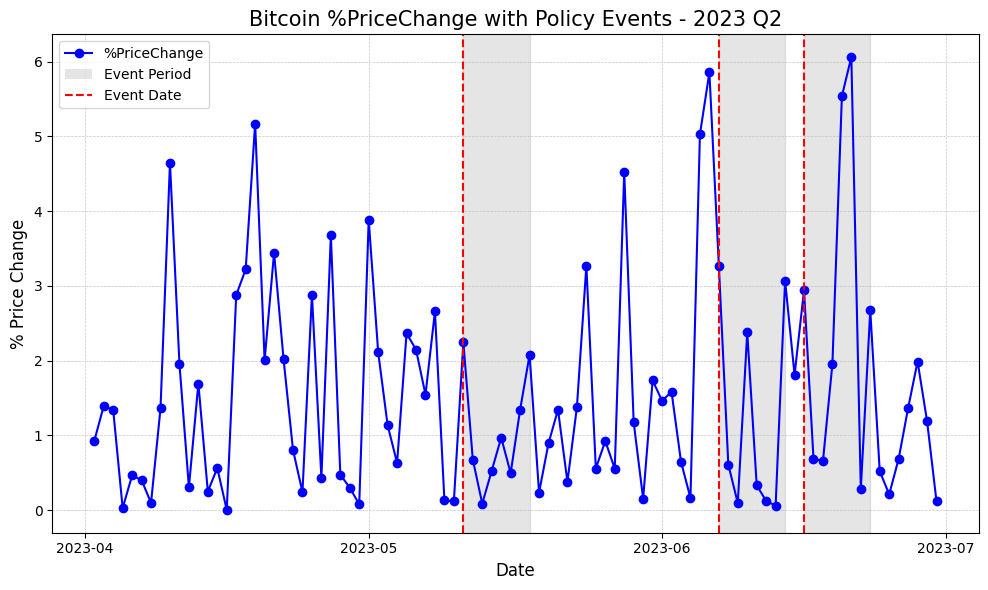

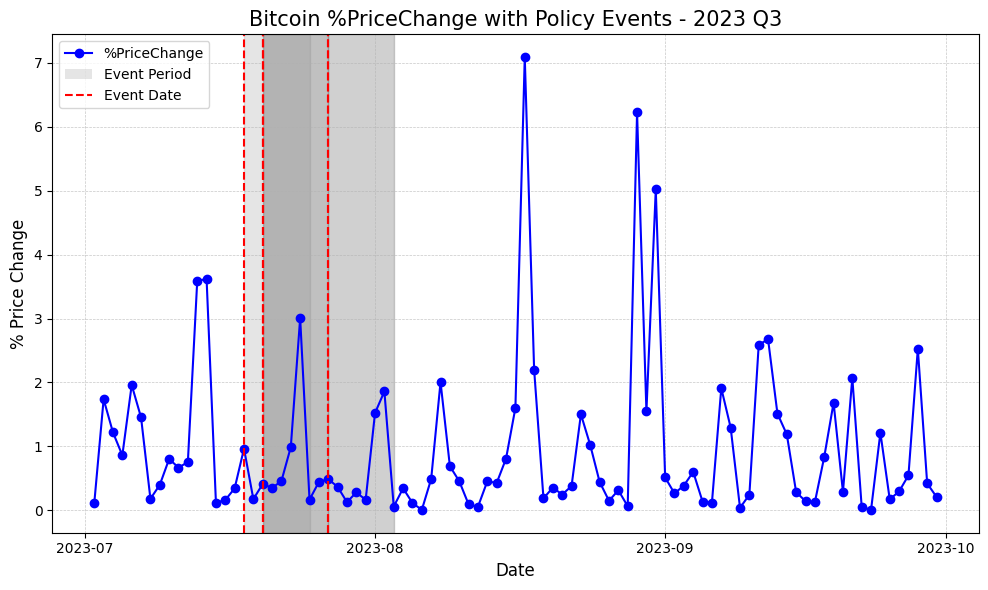

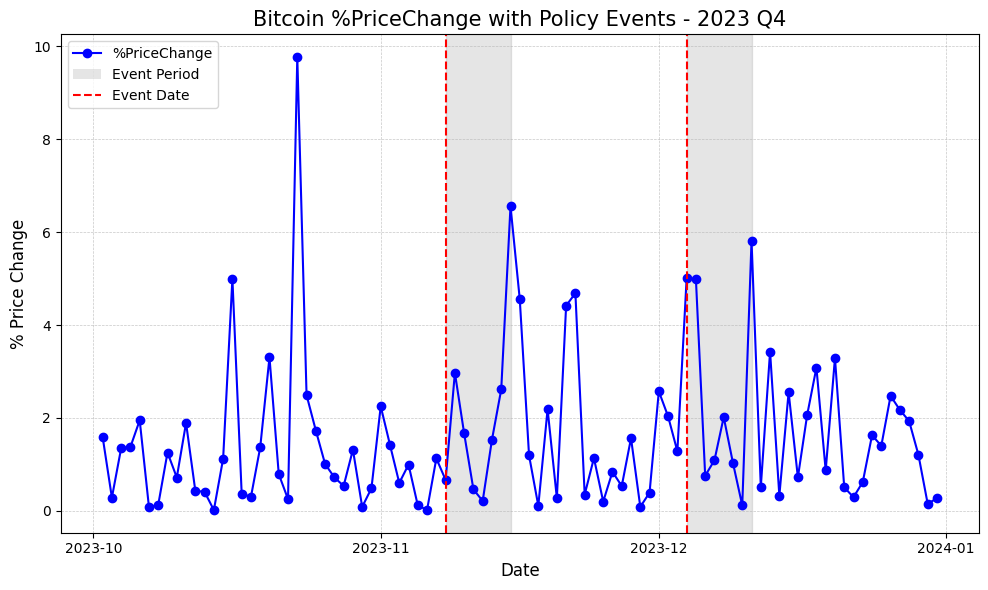

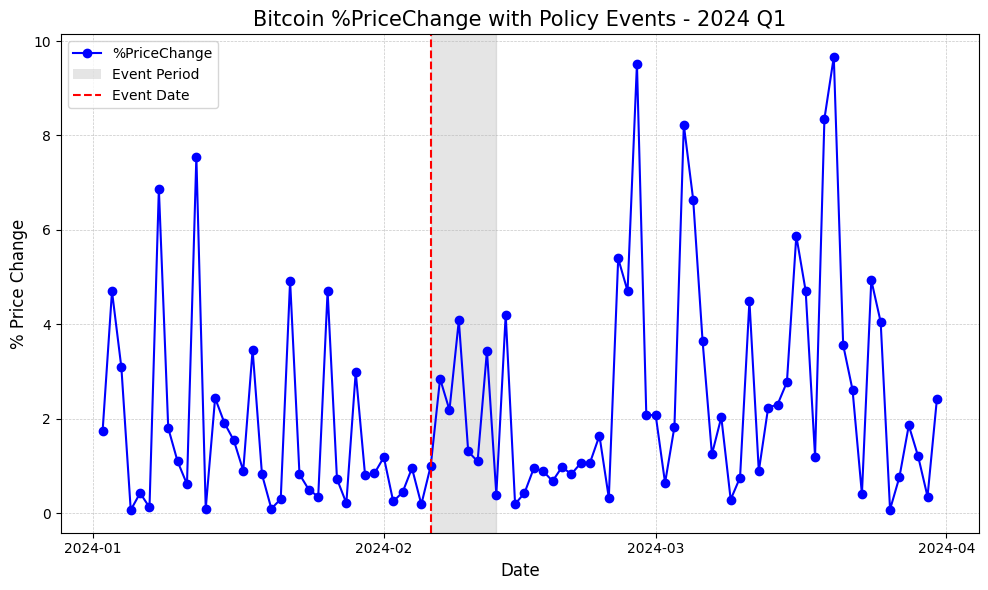

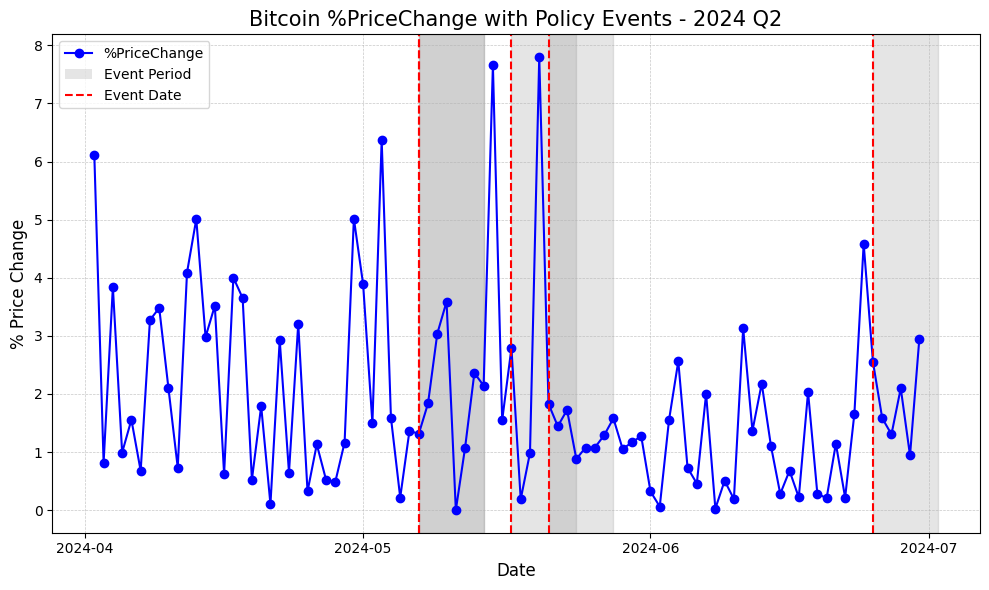

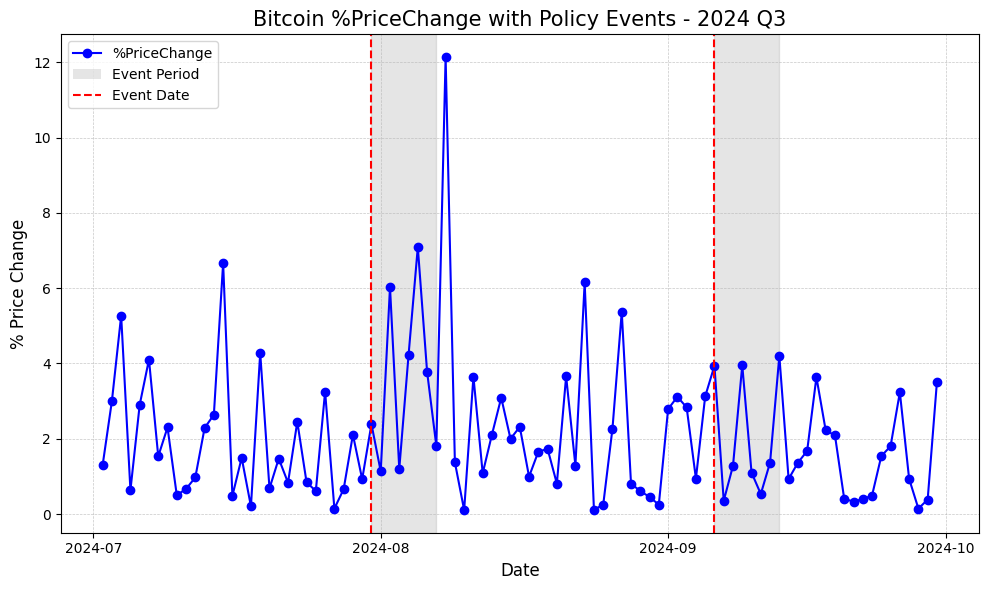

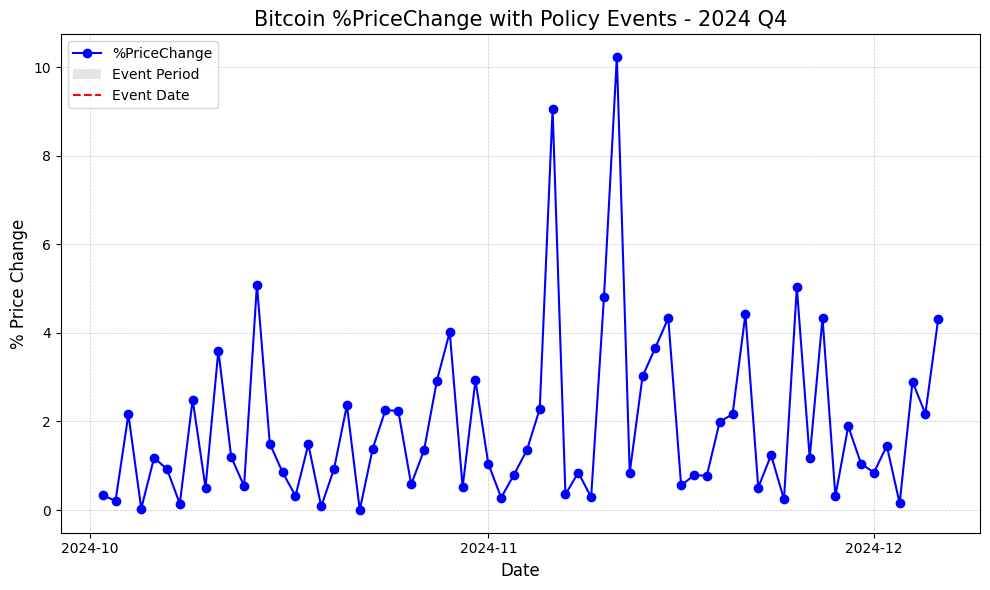

In [135]:
plot_quarterly_trend(bitcoin_df, law_df, '%PriceChange')

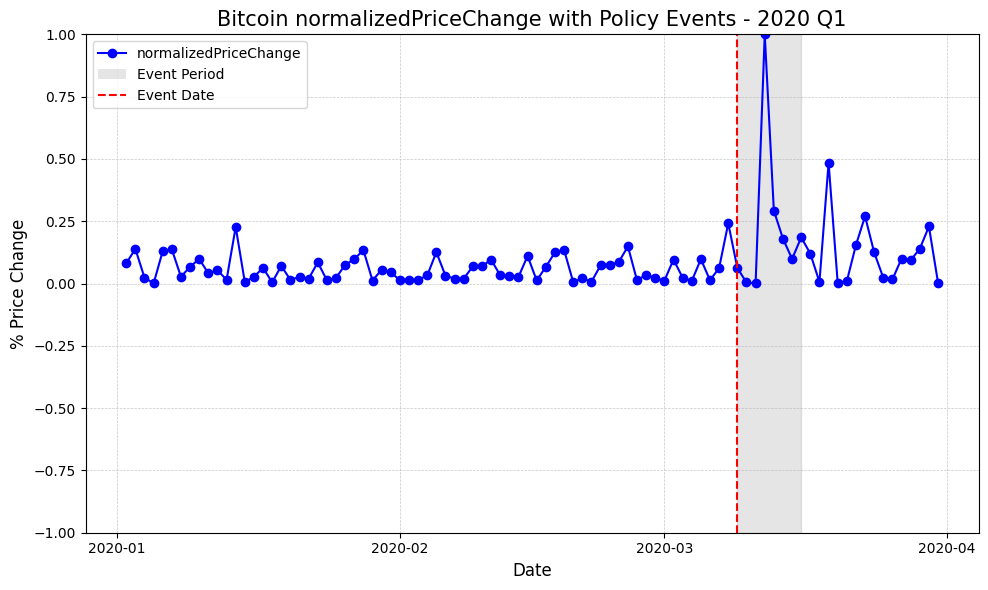

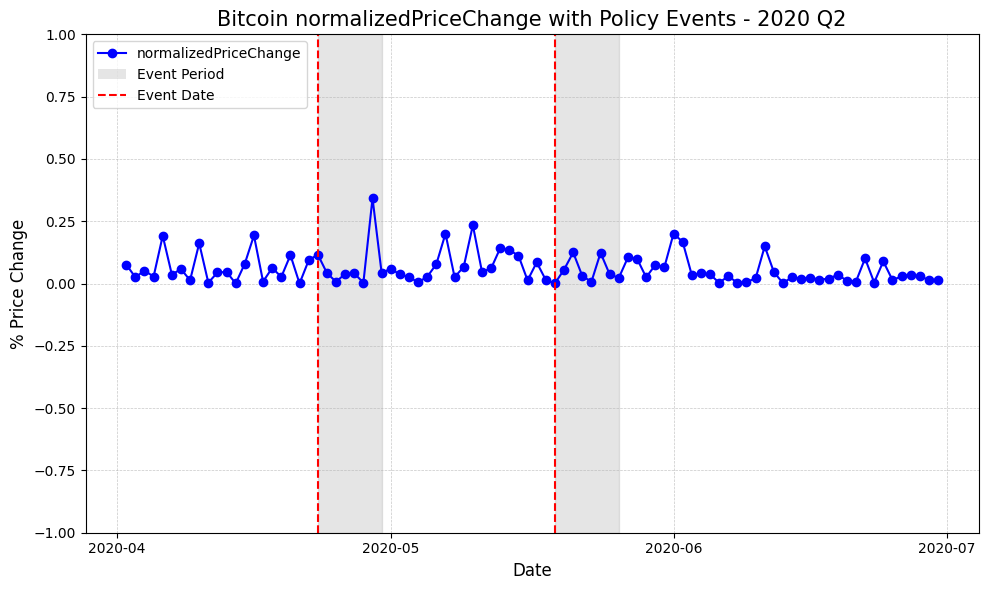

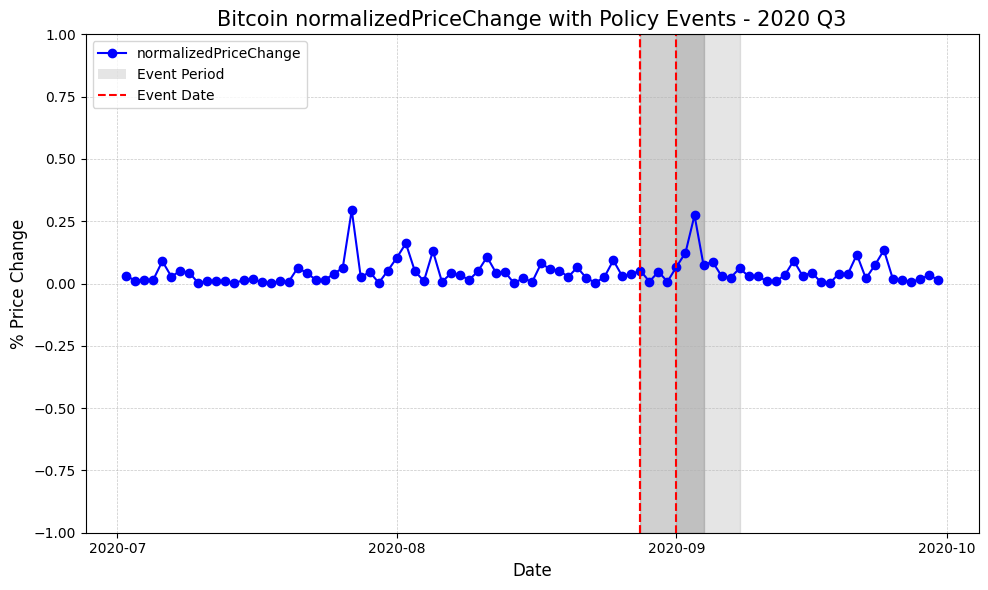

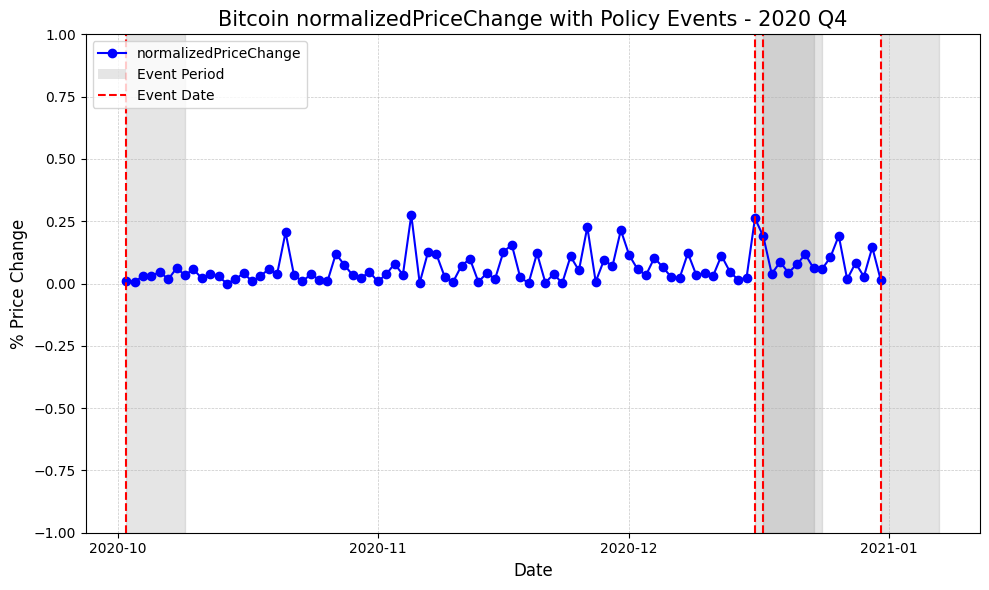

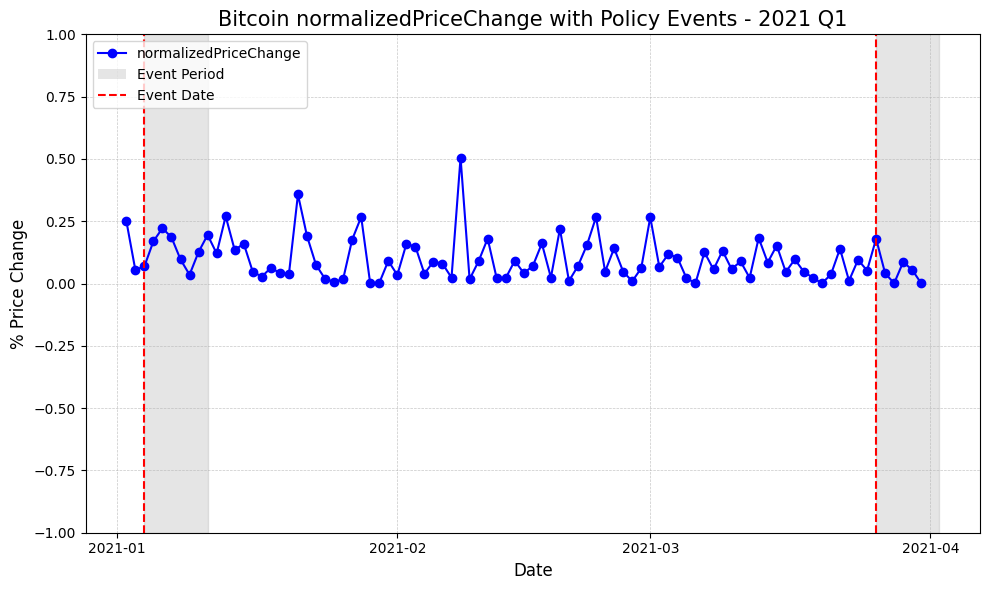

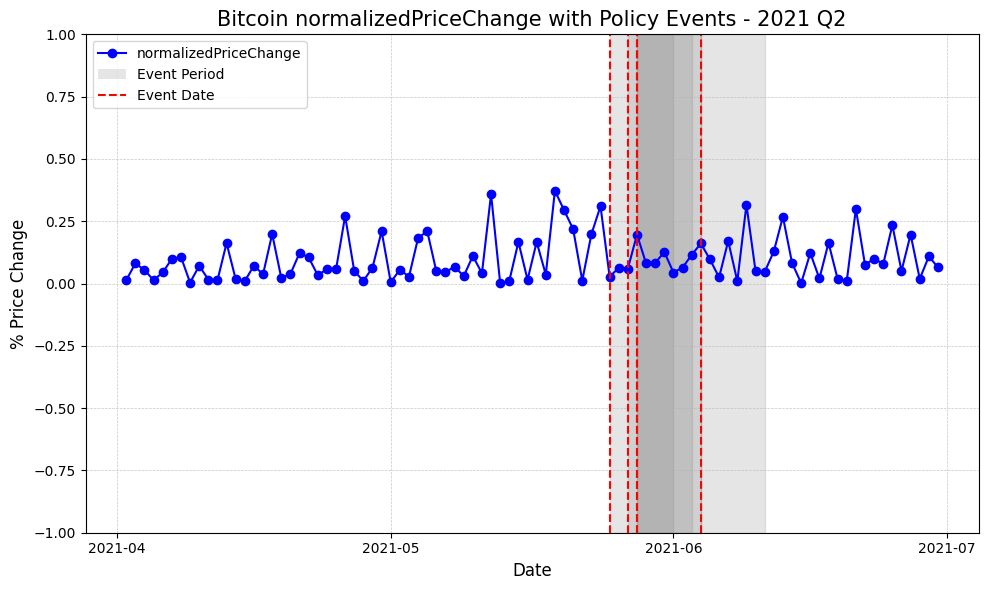

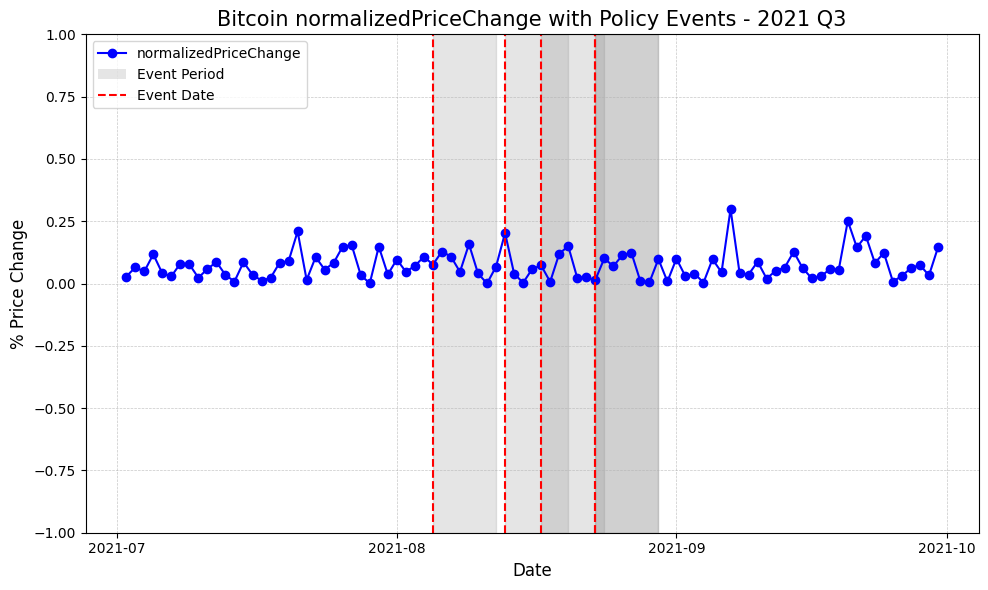

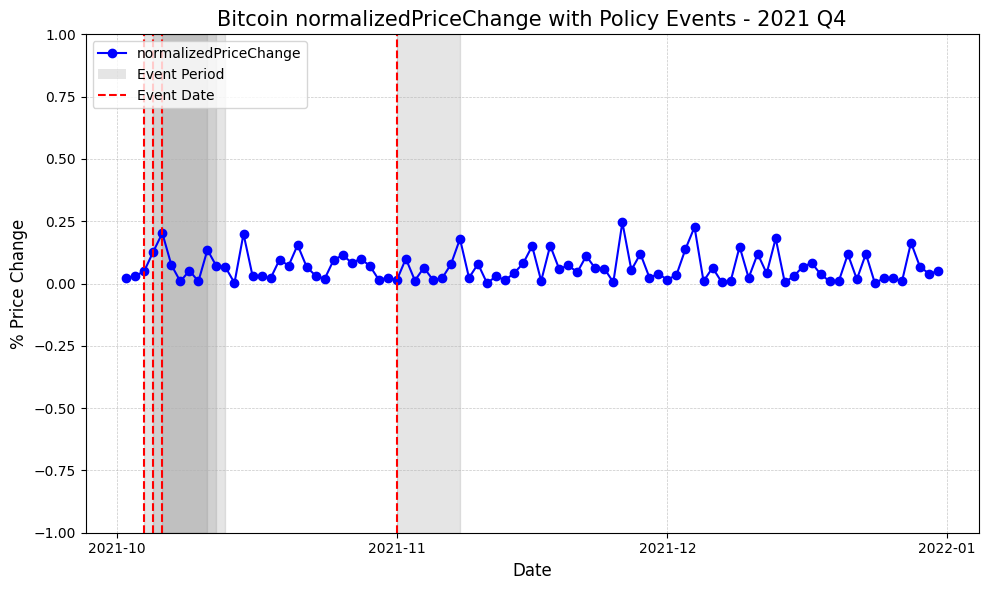

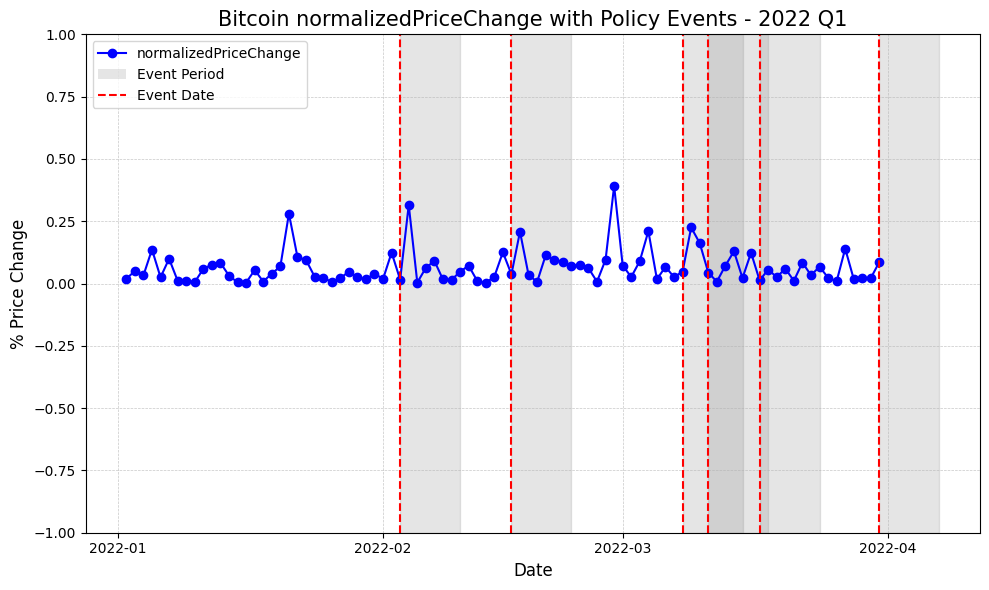

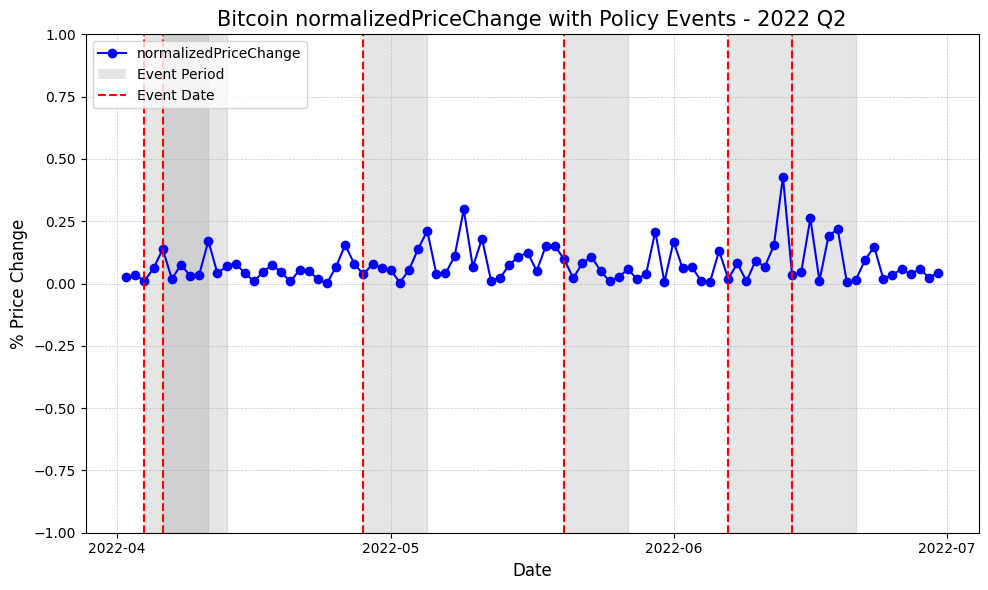

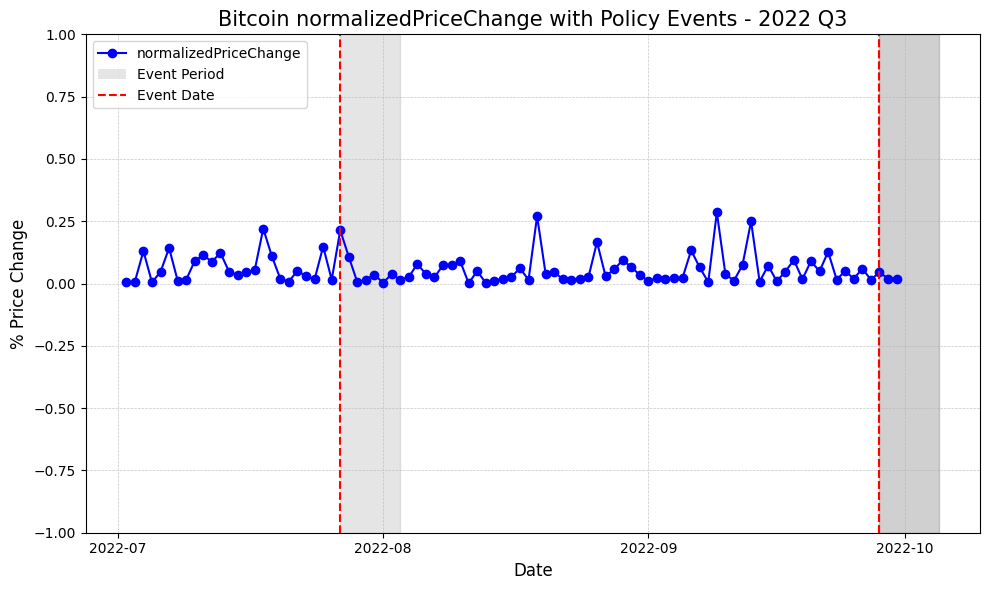

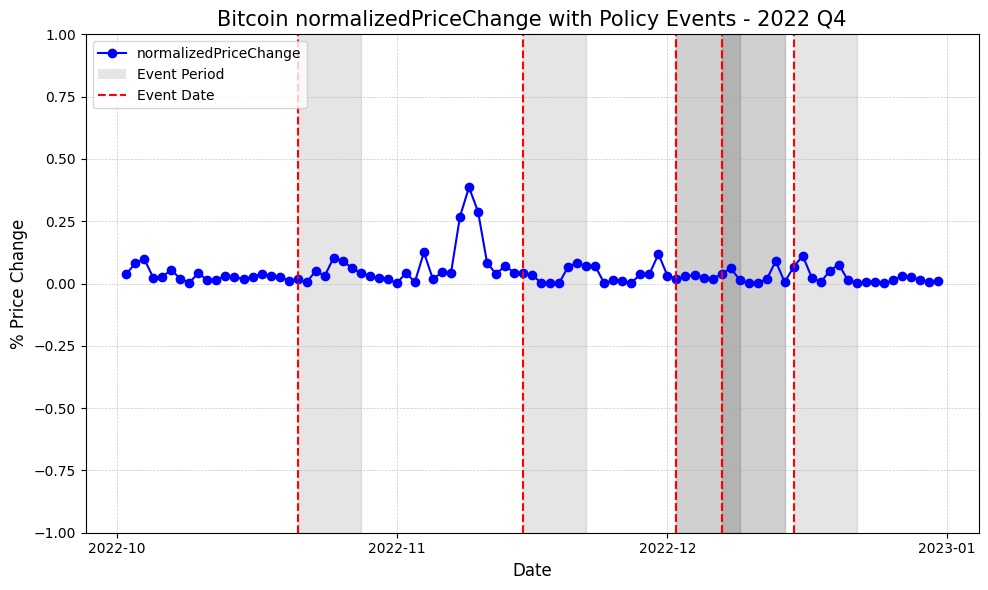

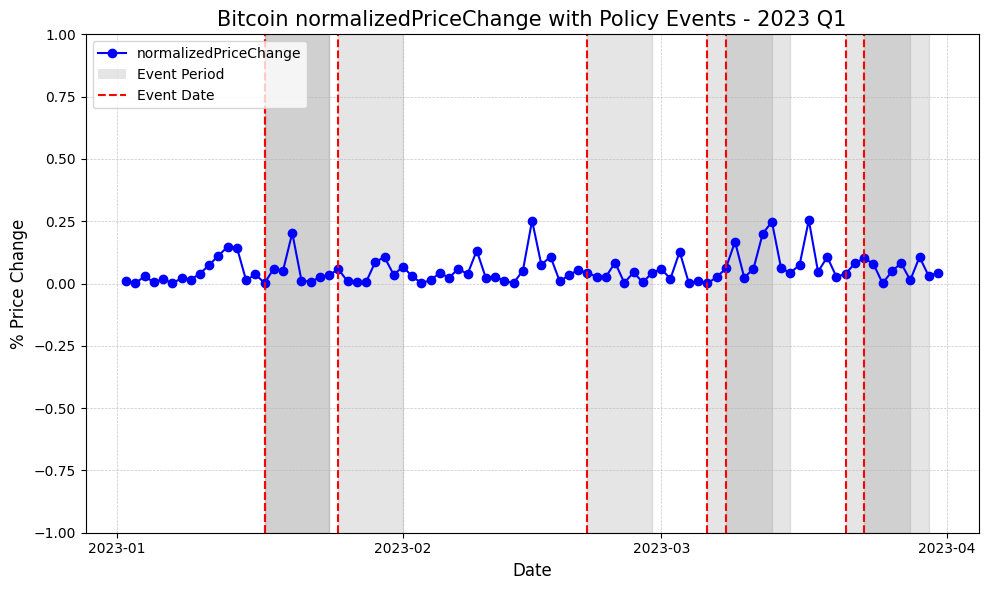

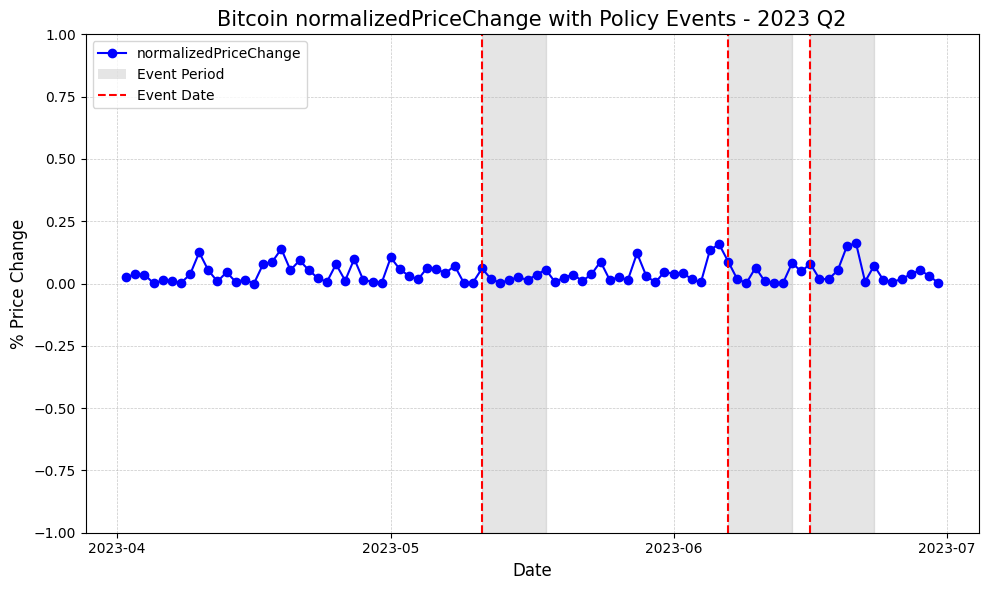

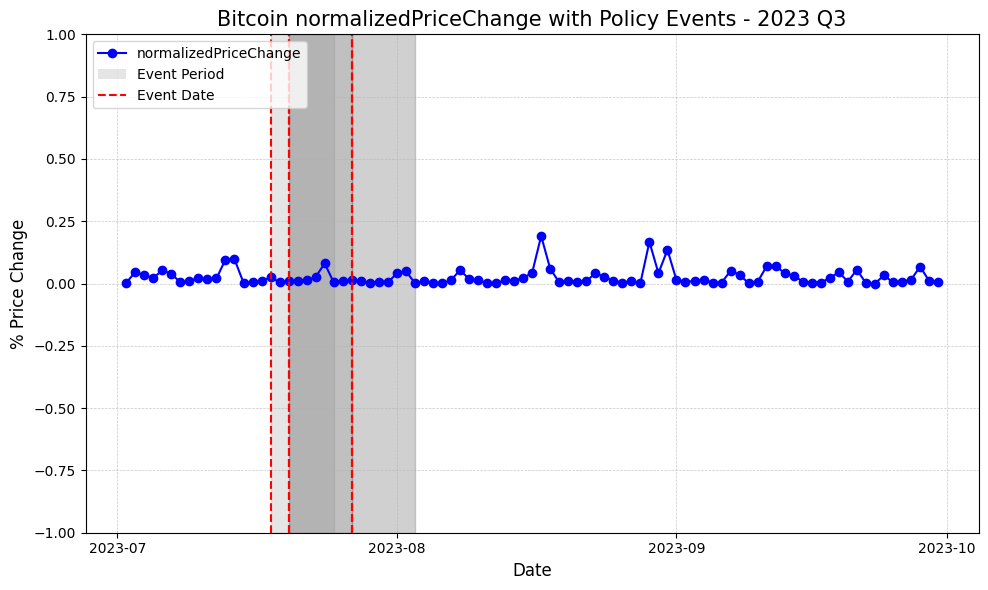

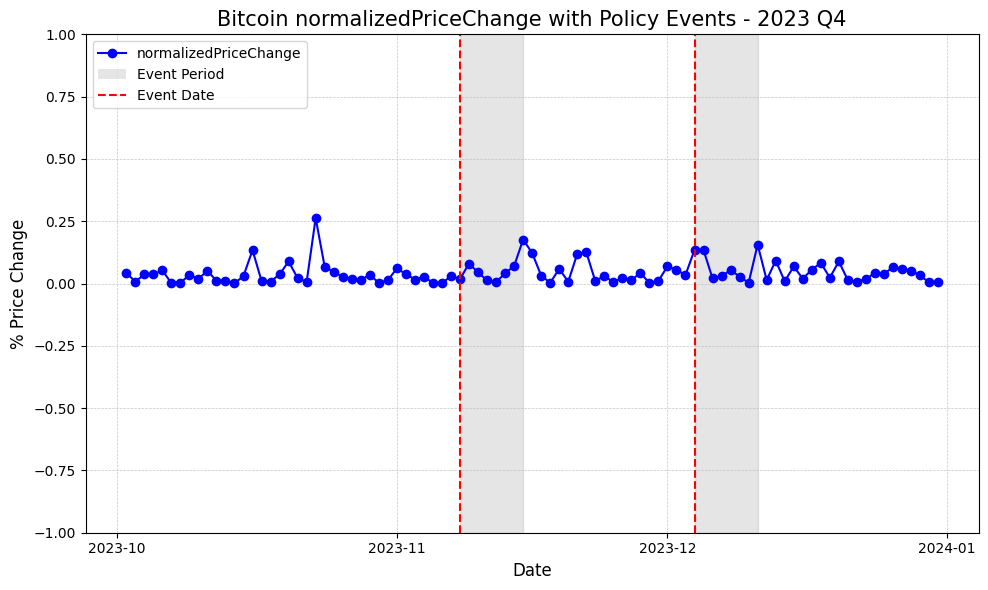

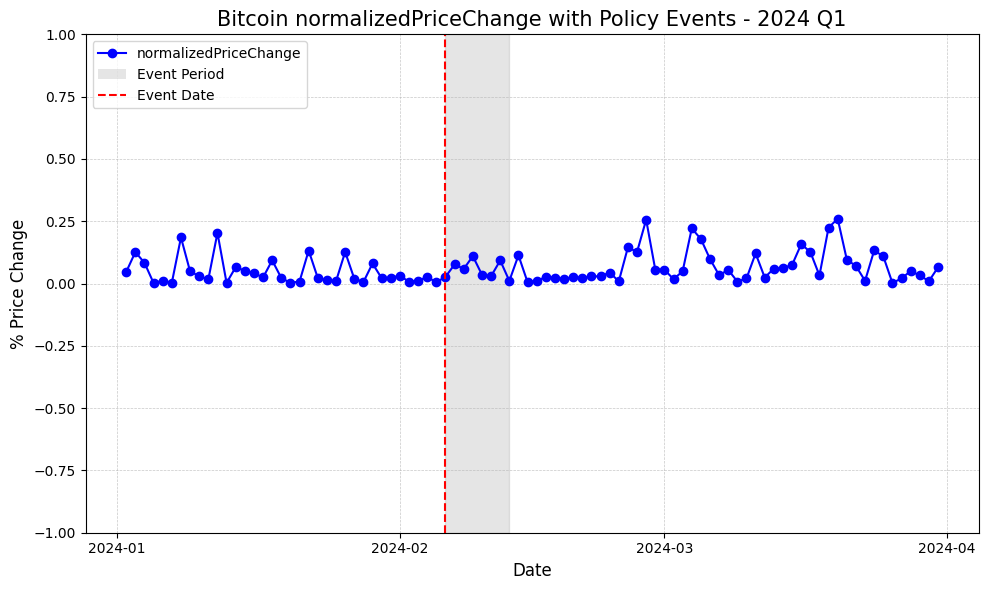

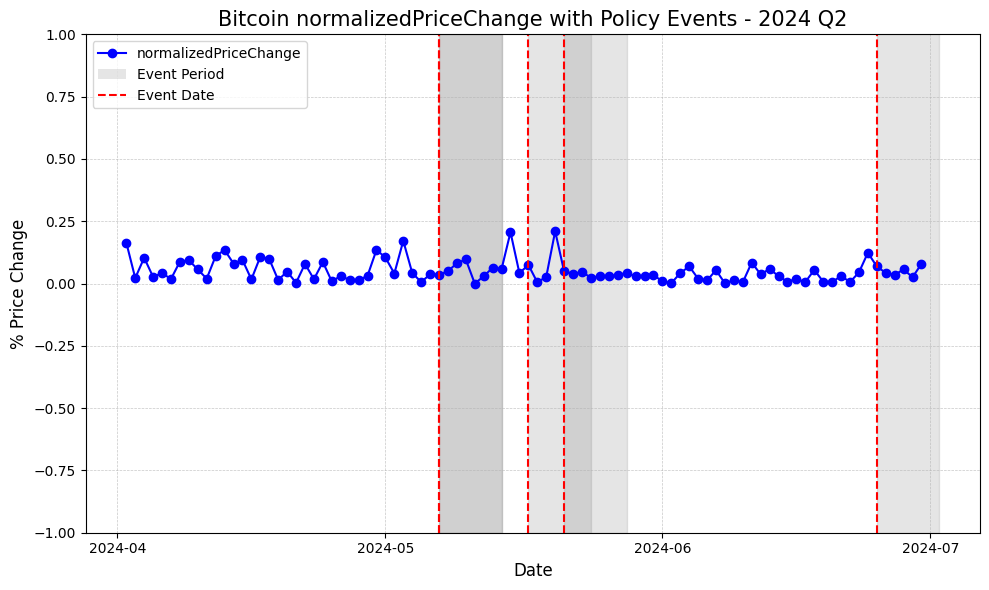

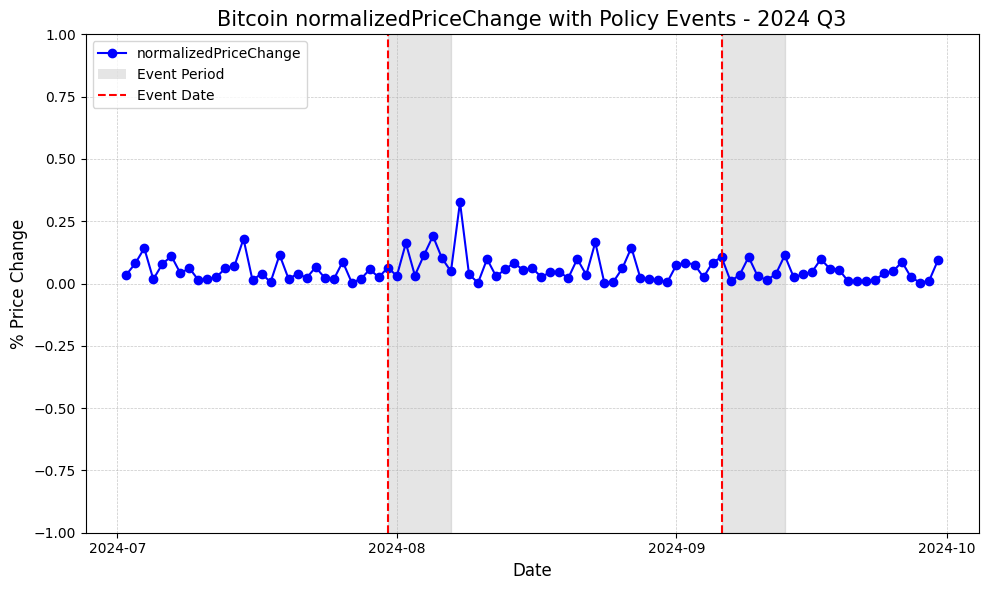

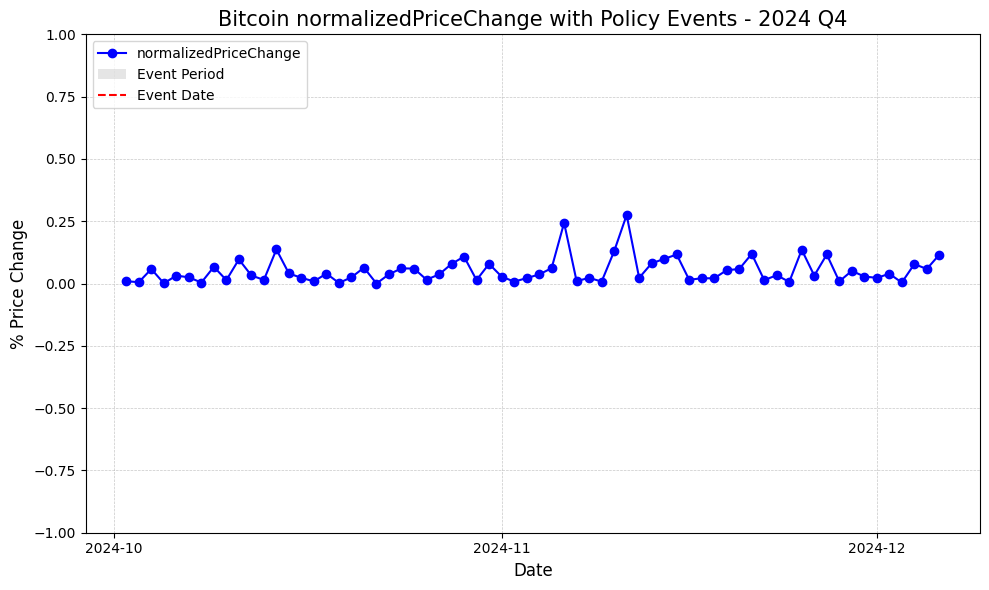

In [136]:
plot_quarterly_trend(bitcoin_df, law_df, 'normalizedPriceChange', y_axis_limit = True)